ensia-logo.png

---
# **Introduction to Artificial Intelligence**

> ## AI-Powered Stock Investment Optimization :

## Overview:
Stock Market Investment Optimization is an AI-powered application that helps users allocate their investments across multiple companies to maximize return on investment (ROI). The system considers real-time stock market data, individual risk tolerance, and investment goals to provide optimized investment recommendations.

## Features
- **Real-time Stock Data Collection**: Uses Yahoo Finance's API to fetch stock prices, financial news, and market trends.
- **User Input Handling**: Allows users to specify investment capital, risk level (conservative, moderate, aggressive), investment duration, and industry preferences.

## Application Components
1. **Data Collection & Processing**:
   - Fetch historical and real-time stock market data.
   - Analyze stock performance metrics (P/E ratio, market cap, price fluctuations, etc.).
   - Research market trends and economic forecasts.
2. **Optimization Algorithms**:
   - Implement and compare Greedy Search, A*, and Simulated Annealing.
   - Model portfolio allocation as a CSP.
3. **Investment Strategy Dashboard**:
   - User-friendly interface for inputting investment parameters.
   - Portfolio allocation suggestions with ROI and risk assessment.
   - Visualizations: Portfolio breakdown, risk-return trade-offs, and historical performance graphs.

## Technologies Used
- **Python** (Jupyter Notebook for implementation)
- **APIs** (Alpha Vantage, Yahoo Finance)
- **AI Algorithms** (Greedy, A*, Simulated Annealing, CSP)
- **Visualization** (Matplotlib, Seaborn, Plotly)


---
## **1. Problem Formulation**
---

## Portfolio Optimization with A*/Greedy Search Over Time

We model the problem as a **graph**, where each time step `Tᵢ` (for `i ∈ [0, N]`) represents a moment in time.

At each `Tᵢ`, we perform an **A\* search** or **greedy search**, while maintaining:
- The **heuristic values** from previous steps.
- The **portfolio state** from the previous time.

---

### 🔷 Graph Modeling


- **Nodes** represent an individual from stocks  at a given time.
- **Edges** represent possible trades: **Buy**, **Sell**, or **Hold** between stocks .


## Data Acces :
 ensure to connect to the drive and put the folder of data shared by the team leader in the righat path as montioned in the following cell then you can run the program , tou should ensure that you have the same links of the data files in your directory

In [1]:
from google.colab import drive
import os
import json
import pandas as pd

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Navigate to your project folder
project_path = '/content/drive/MyDrive/AIProjectData'
os.chdir(project_path)

# 3. Verify files (should match your image)
!ls -l

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
total 6387
-rw------- 1 root root  107828 May  8 17:08 multiple_stocks_ratios.json
-rw------- 1 root root    2659 May  8 17:08 nasdaq_100.json
-rw------- 1 root root    2361 May  8 17:08 one_month_changes.json
-rw------- 1 root root    1835 May  8 17:08 sp500_top150.json
-rw------- 1 root root    9250 May  8 17:08 statistics.json
-rw------- 1 root root    7177 May  3 15:49 Stock_Filter.py
-rw------- 1 root root 3511705 May  8 17:08 stock_prices.json
-rw------- 1 root root    8065 May  8 17:08 stocks_consecutive_day_annual_volatility.json
-rw------- 1 root root 2886957 May  8 17:08 stocks_consecutive_day_volatility.json



  ## Stock Filtering

Filtering consists of selecting stocks from an effectively unlimited pool. It ensures we focus on high-quality candidates that align with our investment goals. Without filtering, we risk being overwhelmed by irrelevant data and suboptimal choices.

---

### 📊 Filtering Criteria

We apply filters based on:

- **PEG Ratio**: Measures valuation relative to growth potential.
  - **Short-Term**: Focus on low PEG (< 1) for undervalued stocks with high growth potential.
  - **Long-Term**: Prefer moderate PEG (∼1) for stable, consistent growth.

- **Volatility**:
  - **Short-Term**: High volatility indicates opportunities for quick profits.
  - **Long-Term**: Low volatility ensures stability and reduces drawdown risks.

- **Sector/Industry Alignment**:  
  Align stocks with user interests (e.g., technology, agriculture, energy).

- **Momentum Indicators**:  
  For short-term strategies, prioritize stocks showing upward trends.


In [2]:
import requests
import pandas as pd
import json
import yfinance as yf
import numpy as np
import os

api_key = "h7ZyUhBsyk1VdFMw3iigWFcuvWP0aR7O"

start_D = "2020-01-01"
end_D = "2025-01-01"



def safe_json_dump(data, filepath):
    def clean(obj):
        if isinstance(obj, dict):
            return {k: clean(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [clean(v) for v in obj]
        elif isinstance(obj, (np.integer, int)):
            return int(obj)
        elif isinstance(obj, (np.floating, float)):
            return None if np.isnan(obj) else float(obj)
        return obj
    with open(filepath, "w") as f:
        json.dump(clean(data), f, indent=4)


def update_nasdaq_100():
    url = "https://topforeignstocks.com/indices/the-complete-list-of-constituents-of-the-nasdaq-100-index/"
    url2 = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
    tables = pd.read_html(url)
    nasdaq_tickers = tables[0].iloc[:, 2].dropna().tolist()[:100]  # Take the first 100 from Nasdaq
    sp500_tickers = pd.read_csv(url2)["Symbol"].dropna().tolist()[:150]  # Take the first 150 from S&P 500
    tickers = list(dict.fromkeys(nasdaq_tickers + sp500_tickers))  # Remove duplicates while preserving order
    safe_json_dump(tickers, '/nasdaq_100.json')


def Stocks_Infos():
    with open('nasdaq_100.json') as f:
        symbols = json.load(f)
    results = []
    for symbol in symbols:
        url = f"https://financialmodelingprep.com/api/v3/ratios-ttm/{symbol}?apikey={api_key}"
        resp = requests.get(url)
        if resp.status_code == 200:
            data = resp.json()
            for item in data:
                item["symbol"] = symbol
                if "dividendYielTTM" in item:
                    item["dividendYieldTTM"] = item.pop("dividendYielTTM")
            results.extend(data)
    safe_json_dump(results, 'multiple_stocks_ratios.json')


def fetch(stocks, start_date=start_D, end_date=end_D):
    cleaned = [s.strip().upper() for s in stocks if isinstance(s, str) and s.strip()]
    combined = pd.DataFrame()
    for i in range(0, len(cleaned), 20):
        chunk = cleaned[i:i+20]
        try:
            data = yf.download(chunk, start=start_date, end=end_date, progress=False)
        except:
            continue
        if data.empty:
            continue
        if isinstance(data.columns, pd.MultiIndex):
            if 'Close' in data.columns.levels[0]:
                data = data['Close']
            else:
                continue

        for col in data.columns:
            data[col] = data[col].ffill(limit=5)

        data = data.dropna(how='all')
        combined = pd.concat([combined, data], axis=1)
    if combined.empty:
        return pd.DataFrame()

    prices_dict = combined.where(pd.notnull(combined), None).to_dict(orient="list")
    safe_json_dump(prices_dict, "stock_prices.json")

    if combined.shape[0] > 21:
        last = combined.iloc[-1]
        month_ago = combined.iloc[-22]
        pct = ((last - month_ago) / month_ago).round(6)
        safe_json_dump(pct.to_dict(), "one_month_changes.json")

    return combined


def get_statistics(stocks, start_date=start_D, end_date=end_D):
    data = fetch(stocks, start_date, end_date)
    if data.empty:
        return {}
    data = data.dropna(axis=1, how='all')
    if data.empty:
        return {}
    returns = data.pct_change(fill_method=None).dropna(how='all')
    if returns.empty:
        return {}
    exp = returns.mean()
    vol = returns.std()
    stats = {
        sym: {
            "expected_return": round(exp[sym], 6) if not pd.isna(exp[sym]) else None,
            "volatility": round(vol[sym], 6) if not pd.isna(vol[sym]) else None
        }
        for sym in exp.index
    }
    safe_json_dump(stats, "statistics.json")
    return stats


def calculate_volatilities():
    with open("stock_prices.json") as f:
        price_data = json.load(f)
    daily_vol = []
    annual_vol = []
    for sym, prices in price_data.items():
        if len(prices) < 2:
            continue
        log_r = [np.log(prices[i] / prices[i - 1])
                 for i in range(1, len(prices))
                 if prices[i] is not None and prices[i - 1] is not None]
        if not log_r:
            continue
        daily_vol.append({"symbol": sym, "log_returns": [round(r, 6) for r in log_r]})
        annual_vol.append({
            "symbol": sym,
            "annual_volatility": round(np.std(log_r) * np.sqrt(252), 6)
        })
    safe_json_dump(daily_vol, "stocks_consecutive_day_volatility.json")
    safe_json_dump(annual_vol, "stocks_consecutive_day_annual_volatility.json")


def load_merged_data():
    with open("statistics.json") as f:
        stats = json.load(f)
    with open("multiple_stocks_ratios.json") as f:
        ratios = json.load(f)
    with open("stocks_consecutive_day_annual_volatility.json") as f:
        ann = json.load(f)
    stats_df = pd.DataFrame.from_dict(stats, orient="index")
    ratios_df = pd.DataFrame(ratios)
    ann_df = pd.DataFrame(ann).set_index("symbol")
    df = ratios_df.set_index("symbol").join(stats_df).join(ann_df)
    try:
        with open("one_month_changes.json") as f:
            onem = json.load(f)
        df = df.join(pd.DataFrame.from_dict(onem, orient="index", columns=["1M_pct_change"]))
    except FileNotFoundError:
        pass
    return df


def get_top_short_term(df, top_n=10):
    df2 = df.dropna(subset=["expected_return", "volatility", "1M_pct_change"]).copy()
    df2.loc[:, "score"] = (
        df2["expected_return"].rank(ascending=False) +
        df2["1M_pct_change"].rank(ascending=False) +
        df2["volatility"].rank(ascending=True)
    ).round(6)
    df3 = df2.reset_index().sort_values(
        by=["score", "symbol"],
        ascending=[False, True],
        kind="mergesort"
    )
    return df3["symbol"].tolist()[:top_n]


def get_top_long_term(df, top_n=10):
    df2 = df.dropna(subset=[ #
        "returnOnEquityTTM",
        "freeCashFlowPerShareTTM",
        "netProfitMarginTTM",
        "pegRatioTTM",
        "debtRatioTTM"
    ]).copy()
    df2.loc[:, "score"] = (
        df2["returnOnEquityTTM"].rank(ascending=False) +
        df2["freeCashFlowPerShareTTM"].rank(ascending=False) +
        df2["netProfitMarginTTM"].rank(ascending=False) +
        df2["pegRatioTTM"].rank(ascending=True) +
        df2["debtRatioTTM"].rank(ascending=True)
    ).round(6)
    df3 = df2.reset_index().sort_values(
        by=["score", "symbol"],
        ascending=[False, True],
        kind="mergesort"
    )
    return df3["symbol"].tolist()[:top_n]


def get_filtered_stocks(update=False):
    if update:
        update_nasdaq_100()
        with open("nasdaq_100.json") as f:
            ticks = json.load(f)
        Stocks_Infos()
        get_statistics(ticks)
        calculate_volatilities()
    df = load_merged_data()
    return {
        "top_short_term": get_top_short_term(df),
        "top_long_term": get_top_long_term(df)
    }

if __name__ == "__main__":
    stocks = get_filtered_stocks(update=False)
    print("Top Short Term Stocks:")
    print(stocks["top_short_term"])
    print("\nTop Long Term Stocks:")
    print(stocks["top_long_term"])

Top Short Term Stocks:
['CHTR', 'BIIB', 'DASH', 'ADBE', 'CSGP', 'ABNB', 'CMCSA', 'AMD', 'BKR', 'AXON']

Top Long Term Stocks:
['AEP', 'CRWD', 'DASH', 'DDOG', 'CSGP', 'AMZN', 'CCEP', 'CMCSA', 'AZN', 'AVGO']


## Class Definition :

In [3]:
class StockItem:
    """
    Represents an individual stock item with a stock name and the amount owned.
    """
    def __init__(self, stock, amt=1):
        """
        Initializes a stock item.

        :param stock: The name of the stock.
        :param amt: The amount of the stock owned (default is 1).
        """
        self.stock = stock
        self.amt = amt

class Stocks:
    """
    Represents a stock portfolio where users can buy and sell stocks using available funds.
    """
    def __init__(self, funds, stocks=None):
        """
        Initializes the Stocks portfolio.

        :param funds: Initial amount of funds available.
        :param stocks: Optional list of StockItem objects representing owned stocks.
        """
        self.funds = funds
        self.stocks = stocks if stocks is not None else []
        self.value  = 0

    def get_stocks(self):
        return self.stocks
    def get_funds(self):
      return self.funds
    def buy(self, stock, price , show_res  = True):
        """
        Purchases a stock if sufficient funds are available.

        :param stock: The name of the stock to buy.
        :param price: The price of the stock.
        """
        if self.funds < price:
            print(f"Insufficient funds to buy {stock}. Available: ${self.funds:.2f}, Required: ${price:.2f}")
            return

        self.funds -= price  # Deduct the stock price from funds
        found = False

        # Check if the stock is already owned
        for el in self.stocks:
            if el.stock == stock:
                el.amt += 1  # Increase the stock amount
                found = True
                break

        # If stock is not found, add a new entry
        if not found:
            self.stocks.append(StockItem(stock))
        if show_res:
          print(f"Bought 1 share of {stock} for ${price:.2f}. Remaining funds: ${self.funds:.2f}")

    def sell(self, stock, price , show_res  = True):
        """
        Sells a stock if the user owns it.

        :param stock: The name of the stock to sell.
        :param price: The price of the stock at the time of selling.
        """
        for el in self.stocks:
            if el.stock == stock:
                el.amt -= 1  # Reduce stock amount
                self.funds += price  # Add the selling price to funds

                # Remove the stock from the list if the amount reaches zero
                if el.amt == 0:
                    self.stocks.remove(el)

                if show_res:
                  print(f"Sold 1 share of {stock} for ${price:.2f}. Updated funds: ${self.funds:.2f}")
                return

        print(f"Cannot sell {stock}: Not owned.")

    def has_stock(self, stock):
        """
        Checks if a stock exists in the portfolio.

        :param stock: The name of the stock to check.
        :return: True if the stock is in the portfolio, False otherwise.
        """
        return any(el.stock == stock for el in self.stocks)
    def get_stock (self , stock):
      for st in self.stocks :
        if st.stock == stock :
          return st.amt
      return 0
    def eval_por(self, stocks):
      prix = 0
      for stock in stocks :
        if self.has_stock(stock["symbol"]):
          prix = prix + self.get_stock(stock)
      return prix

    def percentage(self, stock):
        """
        Calculates the percentage of a specific stock in the portfolio.

        :param stock: The name of the stock to calculate percentage for.
        :return: The percentage of the stock in the portfolio, or 0 if not found or total is zero.
        """
        if not self.has_stock(stock):
            return 0.0

        total = sum(el.amt for el in self.stocks)  # Total number of shares
        if total == 0:  # Prevent division by zero
            return 0.0

        for el in self.stocks:
            if el.stock == stock:
                return el.amt / total
        return 0.0  # Fallback, though has_stock ensures this shouldn't happen

    def display_portfolio(self):
        """
        Displays the current stock holdings and available funds.
        """
        print(f"\nAvailable funds: ${self.funds:.2f}")
        if not self.stocks:
            print("Stock Portfolio is empty.")
        else:
            print("Stock Portfolio:")
            for stock in self.stocks:
                print(f"- {stock.stock}: {stock.amt} shares")
        print("-" * 30)
    def transition(self, funds, dayPrices):
    # Create price lookup dictionary
      prices = {price["symbol"]: price['price'] for price in dayPrices}

      # Create stock information dictionary
      stck = {}
      for stock in self.stocks:
          symbol = stock.stock
          stck[symbol] = {
              "price": prices[symbol],
              "amt": self.get_stock(symbol),
              "per": self.percentage(symbol)
          }

      # Update funds
      self.funds = funds

      # Clear current stocks (after we've used them for calculations)
      self.stocks = []

      # Rebuild portfolio according to percentages
      for symbol, det in stck.items():
          if det["per"] <= 0:  # Skip if percentage is 0 or negative
              continue

          # Calculate amount to buy (using available funds)
          amount_to_spend = funds * det["per"]
          num_to_buy = int(amount_to_spend // det["price"])

          # Execute buys
          for _ in range(num_to_buy):
              if self.funds >= det["price"]:  # Check if we can afford it
                  self.buy(symbol, det["price"])
              else:
                  break  # Stop if we run out of money

    def __lt__(self, other):
        # Define how nodes should be compared
        # For example, compare by heuristic value:
        return self.get_heu() < other.get_heu()

    # Optionally implement other comparison methods
    def __eq__(self, other):
        return self.get_heu() == other.get_heu()



## Structring  the obtained data :

In [4]:
!pip install yfinance --upgrade
import yfinance as yf
from datetime import datetime, timedelta
import time
import json

def get_stock_data(stock_symbols, start_date, end_date):
    """
    Fetch stock data for given symbols between two dates.

    Args:
        stock_symbols (list): List of stock symbols (e.g., ['AAPL', 'MSFT']).
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
        list: A list of dictionaries containing stock symbols and their close prices.
    """
    # Convert string dates to datetime objects
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    # Calculate the time delta between start and end dates
    delta = end - start

    # Determine the appropriate interval based on the time range
    if delta <= timedelta(days=7):
        interval = '1m'  # 1 minute for intraday data (max 7 days)
    elif delta <= timedelta(days=60):
        interval = '5m'  # 5 minutes for short-term
    elif delta <= timedelta(days=365):
        interval = '1d'  # daily for medium-term
    else:
        interval = '1wk'  # weekly for long-term

    results = []

    for stock in stock_symbols:
        # Fetch stock data using yfinance
        stock_data = yf.download(stock, start=start_date, end=end_date, interval=interval)
        # Extract close prices as a list
        close_dic = stock_data['Close'].to_dict().values()
        close_prices =list(key.values() for key in close_dic)
        prix = []
        for el in close_prices :
          for val in el:
             prix.append(val)


        # Append the result for this stock to the results list
        results.append({
            'symbol': stock ,
            'prices': prix
        })

    return results



---
1.Node representation
---

In [5]:
class Node:
    """
    Represents a node in a graph, typically used in search algorithms like A* or BFS.

    Attributes:
        value (float): The value associated with this node (e.g., stock price).
        heuristic (float): The heuristic value estimating the cost to reach the goal.
        symbol (str): A unique identifier for the node (e.g., stock symbol).
        action (str): The action associated with this node (e.g., 'buy', 'sell', 'hold').
        neighbors (list): A list of neighboring nodes connected to this node.
        parent (Node): The parent node in the search tree.
    """

    def __init__(self, stock, heuristic, parent=None, neighbors=None):
        """
        Initializes a Node object.

        :param stock: A dictionary or object containing stock details (symbol, action, value).
        :param heuristic: The heuristic value for the node.
        :param parent: The parent node in the search tree (default is None).
        :param neighbors: A list of neighboring nodes (default is an empty list).
        """
        self.value = stock.get("value", 0)  # Cost of the stock (default to 0 if not provided)
        self.heuristic = heuristic  # Heuristic value
        self.symbol = stock.get("symbol", "unknown")  # Stock symbol (default to 'unknown' if not provided)
        self.action = stock.get("action", "none")  # Action (default to 'none' if not provided)
        self.neighbors = neighbors if neighbors is not None else []  # Neighbors list
        self.parent = parent  # Parent node

    @property
    def set_cop_stock(self):
        """Returns a dictionary representation of the stock data."""
        return {
            "symbol": self.symbol,
            "action": self.action,
            "value": self.value
        }

    def add_neighbor(self, neighbor):
        """
        Adds a neighboring node to this node's neighbors list.

        :param neighbor: The neighboring node to add.
        """
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)

    def remove_neighbor(self, neighbor):
        """
        Removes a neighboring node from this node's neighbors list.

        :param neighbor: The neighboring node to remove.
        """
        if neighbor in self.neighbors:
            self.neighbors.remove(neighbor)

    def set_parent(self, parent):
        """Sets the parent node."""
        self.parent = parent

    def get_Key(self):
        """Returns a unique key for the node combining symbol and action."""
        return f"{self.symbol}_{self.action}"

    def get_heu(self):
        """Returns the heuristic value of the node."""
        return self.heuristic

    def get_copy(self):
        """Returns a copy of the node."""
        copy_node = Node(self.set_cop_stock, self.heuristic)
        return copy_node

    def __repr__(self):
        """
        String representation of the node for debugging purposes.

        :return: A string summarizing the node's attributes.
        """
        return (
            f"Node(symbol={self.symbol}, action={self.action}, value={self.value:.2f}, "
            f"heuristic={self.heuristic:.2f}, neighbors={len(self.neighbors)})"
        )

## Heursitc Function :


The heuristic function combines various financial metrics to guide portfolio optimization. Each metric plays a specific role in selecting stocks that align with the investor's risk and return preferences.

- **Sharpe Ratio**  
  Prioritizes stocks with high **risk-adjusted returns**. It considers both the excess return over a risk-free rate and the total volatility of returns.

- **Sortino Ratio**  
  Focuses on **downside risk** by isolating harmful volatility, making it more appropriate for risk-averse strategies.

- **Value at Risk (VaR)**  
  Estimates the **maximum expected loss** at a given confidence level under normal market conditions.

- **Conditional Value at Risk (CVaR)**  
  Measures the **average loss** beyond the VaR threshold, capturing extreme tail risks to protect against **catastrophic losses**.

- **Momentum**  
  Indicates short-term or long-term **price movement strength**, helping identify bullish trends.

- **MACD (Moving Average Convergence Divergence)**  
  Highlights **trend reversals** and **momentum shifts** using EMAs.

- **RSI (Relative Strength Index)**  
  Identifies **overbought or oversold** conditions to avoid poorly timed entries or exits.




In [6]:
import random
import numpy as np
from scipy.stats import norm

# Define the list of stock symbols (you can customize this list)
stock_symbols = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "NVDA", "META", "NFLX",
    "AMD", "INTC", "PYPL", "ADBE", "CRM", "AVGO", "QCOM", "TXN",
    "CSCO", "IBM", "ORCL", "VRTX"
]

# Generate the stocks list with 20 stocks, each having 50 random prices
def generate_stock_data():
    stocks = []
    for symbol in stock_symbols:
        # Generate 50 random prices between 50 and 500
        prices = [round(random.uniform(50, 500), 2) for _ in range(80)]
        stocks.append({
            "symbol": symbol,
            "prices": prices
        })
    return stocks

def calculate_returns(prices):
    """Calculate daily returns from a list of prices."""
    returns = np.diff(prices) / prices[:-1]
    return returns

def get_var_and_cvar(stock, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR).

    Args:
        stock (dict): Dictionary containing 'symbol' and 'prices'.
        confidence_level (float): Confidence level for VaR (e.g., 0.95 for 95%).

    Returns:
        tuple: VaR and CVaR values.
    """
    prices = stock["prices"]
    returns = calculate_returns(prices)

    z_score = norm.ppf(1 - confidence_level)  # Z-score for the given confidence level
    mean = np.mean(returns)
    std_dev = np.std(returns)
    var = mean - z_score * std_dev  # VaR formula

    # Calculate CVaR as the mean of losses exceeding VaR
    losses_beyond_var = returns[returns <= var]
    cvar = np.mean(losses_beyond_var) if len(losses_beyond_var) > 0 else var

    return var, cvar  # Return raw VaR/CVaR (negative for losses)

def get_sharpe_ratio(stock, risk_free_rate=0.02, trading_days=252):
    """
    Calculate the Sharpe Ratio for each stock.

    Args:
        stock: dictionary 'symbol' and 'prices'.
        risk_free_rate (float): Annual risk-free rate (default 2%).
        trading_days (int): Number of trading days in the dataset.

    Returns:
        dict: Dictionary with stock symbols as keys and their Sharpe ratio as values.
    """
    symbol = stock["symbol"]
    prices = stock["prices"]
    returns = calculate_returns(prices)

    mean_daily_return = np.mean(returns)
    annual_excess_return = (mean_daily_return * trading_days) - risk_free_rate
    annual_std_dev = np.std(returns) * np.sqrt(trading_days)

    sharpe = annual_excess_return / annual_std_dev if annual_std_dev != 0 else float('inf')
    return round(sharpe, 4) # Clamp negative values to 0

def get_sortino_ratio(stock, risk_free_rate=0.02, trading_days=252):
    """
    Calculate the Sortino Ratio for each stock.

    Args:
        stock: dictionary 'symbol' and 'prices'.
        risk_free_rate (float): Annual risk-free rate (default 2%).
        trading_days (int): Number of trading days in the dataset.

    Returns:
        dict: Dictionary with stock symbols as keys and their Sortino ratio as values.
    """
    symbol = stock["symbol"]
    prices = stock["prices"]
    returns = calculate_returns(prices)

    mean_daily_return = np.mean(returns)
    annual_excess_return = (mean_daily_return * trading_days) - risk_free_rate

    downside_returns = returns[returns < 0]
    downside_deviation = np.std(downside_returns) * np.sqrt(trading_days) if len(downside_returns) > 0 else 0

    sortino = annual_excess_return / downside_deviation if downside_deviation != 0 else float('inf')
    return  round( sortino, 4)  # Clamp negative values to 0

def calculate_ema(prices, span):
    """
    Calculate Exponential Moving Average (EMA).

    Args:
        prices (list): List of stock prices.
        span (int): Span for the EMA (e.g., 12, 26, or 9).

    Returns:
        list: EMA values.
    """
    if not prices or span <= 0:
        raise ValueError("Prices must be non-empty and span must be positive.")

    # Calculate the smoothing factor (alpha)
    alpha = 2 / (span + 1)

    # Initialize the EMA array with the first price
    ema = [prices[0]]

    # Calculate EMA for each subsequent day
    for i in range(1, len(prices)):
        ema_today = prices[i] * alpha + ema[-1] * (1 - alpha)
        ema.append(ema_today)

    return ema
def get_RSI(stock, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given stock.

    Parameters:
        stock (dict): A dictionary containing stock data, including "prices".
        period (int): The number of periods to use for RSI calculation (default is 14).

    Returns:
        float: The RSI value (between 0 and 100).
    """
    prices = stock["prices"]

    # Ensure there are enough prices to calculate RSI
    if len(prices) <= period:
        raise ValueError("Not enough price data to calculate RSI. Need at least `period + 1` prices.")

    # Step 1: Calculate price changes
    price_changes = [prices[i] - prices[i - 1] for i in range(1, len(prices))]

    # Step 2: Separate gains and losses
    gains = [max(change, 0) for change in price_changes]  # Positive changes or 0
    losses = [-min(change, 0) for change in price_changes]  # Absolute values of negative changes or 0

    # Step 3: Calculate average gains and losses over the specified period
    avg_gain = np.mean(gains[:period])  # SMA of first N gains
    avg_loss = np.mean(losses[:period])  # SMA of first N losses

    # Avoid division by zero
    if avg_loss == 0:
        return 100  # RSI is 100 when there are no losses

    # Step 4: Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Step 5: Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi
def get_MacD(stock):
    prices = stock["prices"]
    if len(prices) < 26:
        return None
    shortEma = calculate_ema(prices[-12:], 12)
    longEma = calculate_ema(prices[-26:], 26)
    macd = [longEma[i] - shortEma[i] for i in range(12)]
    signal_line = calculate_ema(macd[-9:], 9)
    hist = [macd[-9:][i] - signal_line[i] for i in range(9)]
    return round(hist[-1] , 4)
def calc_Momentum(stock , short = False):
    prices = stock['prices']
    T = len(prices)
    n = T//6 if short else T//4
    ti = prices[-1]
    tn = prices[-n]
    return  round((ti - tn )/ tn , 4)

In [7]:
def calculate_heuristics(stock, market_data=None):
    """
    Returns balanced buy/hold/sell scores with all metrics fairly weighted.
    Key improvements:
    1. Normalizes all inputs to [0, 1] using empirical bounds or sigmoid/tanh transformations.
    2. Rebalances weights to prevent any single metric (e.g., Sharpe, VaR) from dominating.
    3. Adds dynamic scaling for momentum, MACD, and RSI.
    4. Incorporates all available metrics: Momentum, MACD, Sharpe, Sortino, VaR/CVaR, RSI, Stability.
    """
    symbol = stock["symbol"]

    # --- Step 1: Normalize All Inputs ---
    # Momentum: Directional strength (tanh bounds to [-1, 1], then shift to [0, 1])
    momentum_short = (np.tanh(calc_Momentum(stock, True)) + 1) / 2  # [0, 1]
    momentum_long = (np.tanh(calc_Momentum(stock, False)) + 1) / 2   # [0, 1]

    # MACD: Sigmoid to bound to [0, 1] (positive = bullish, negative = bearish)
    macd = get_MacD(stock)
    if macd is not None:
        macd_score = 1 / (1 + np.exp(-macd))  # [0, 1]
        neg_macd_score = 1 / (1 + np.exp(macd))  # Flipped for sell signals
    else:
        macd_score = 0.5  # Neutral if MACD cannot be calculated
        neg_macd_score = 0.5

    # RSI: Normalize to [0, 1] (RSI > 70 = overbought, RSI < 30 = oversold)
    rsi = get_RSI(stock)
    rsi_normalized = max(0, min((rsi - 30) / 40, 1))  # Scale RSI to [0, 1]

    # Sharpe/Sortino: Percentile rank (if market_data exists) or softmax scaling
    sharpe = max(0, get_sharpe_ratio(stock))
    sortino = max(0, get_sortino_ratio(stock))
    if market_data:
        sharpe_rank = np.sum(np.array(market_data["sharpes"]) <= sharpe) / len(market_data["sharpes"])
        sortino_rank = np.sum(np.array(market_data["sortinos"]) <= sortino) / len(market_data["sortinos"])
    else:
        sharpe_rank = 1 - np.exp(-0.3 * sharpe)  # Diminishing returns for high Sharpe
        sortino_rank = 1 - np.exp(-0.3 * sortino)

    # VaR/CVaR: Convert risk to "safety" (1 = safest, 0 = extreme risk)
    var, cvar = get_var_and_cvar(stock)
    var_safety = max(0, min(1 + var / 0.3, 1))  # Assume max VaR = -30%
    cvar_safety = max(0, min(1 + cvar / 0.5, 1))  # Assume max CVaR = -50%

    # Stability: Already in [0, 1] (no change)
    stability_short = 1 - min(abs(momentum_short - 0.5) * 2, 1)  # Centered around 0.5
    stability_long = 1 - min(abs(momentum_long - 0.5) * 2, 1)

    # --- Step 2: Rebalanced Weights ---
    # Short-Term Scores
    buy_score_short = (
        0.3 * momentum_short +  # Primary driver
        0.2 * macd_score +      # Trend confirmation
        0.2 * rsi_normalized +  # Overbought/oversold indicator
        0.2 * sharpe_rank +    # Risk-adjusted return filter
        0.05 * var_safety +      # Risk safety
        0.05 * stability_short  # Stability weight
    )

    sell_score_short = (
        0.3 * (1 - momentum_short) +  # Weak momentum
        0.2 * neg_macd_score +        # Bearish trend
        0.2 * (1 - rsi_normalized) +  # Overbought signal
        0.15 * (1 - var_safety) +     # High risk
        0.1 * (1 - cvar_safety) +     # Extreme risk
        0.05 * (1 - stability_short)  # Low stability
    )

    hold_score_short = (
        0.3 * sharpe_rank +
        0.3 * sortino_rank +
        0.2 * stability_short +  # Higher weight on stability
        0.1 * rsi_normalized +    # Neutral RSI preference
        0.1 * var_safety          # Mild risk preference
    )

    # Long-Term Scores
    buy_score_long = (
        0.3 * momentum_long +
        0.2 * macd_score +
        0.2 * rsi_normalized +
        0.15 * sharpe_rank +
        0.1 * var_safety +
        0.05 * stability_long
    )

    sell_score_long = (
        0.3 * (1 - momentum_long) +
        0.2 * neg_macd_score +
        0.2 * (1 - rsi_normalized) +
        0.15 * (1 - var_safety) +
        0.1 * (1 - cvar_safety) +
        0.05 * (1 - stability_long)
    )

    hold_score_long = (
        0.3 * sharpe_rank +
        0.3 * sortino_rank +
        0.2 * stability_long +  # Higher stability weight for long-term
        0.1 * rsi_normalized +
        0.1 * var_safety
    )

    # --- Step 3: Dynamic Scaling ---
    # Ensure no score exceeds 1.0 due to rounding errors
    def clamp(x): return max(0, min(1, x))

    return {
        "symbol": symbol,
        "buy_short": clamp(buy_score_short),
        "sell_short": clamp(sell_score_short),
        "hold_short": clamp(hold_score_short),
        "buy_long": clamp(buy_score_long),
        "sell_long": clamp(sell_score_long),
        "hold_long": clamp(hold_score_long),
    }

## Cost Function :

In [8]:
def evaluate(current_node , portfolio , prices):
    """
    Evaluate the total portfolio value of a given state.
    Parameters:
    - state (dict): Dictionary with stock symbols as keys and info as values.
    Returns:
    - float: Total evaluated portfolio value.
    """
    path=get_path(current_node)
    total_value = 0
    available_funds= portfolio.funds
    prices = {price["symbol"]:price["price"] for price in prices}
    for stock_data in portfolio.stocks:
        shares = stock_data.amt
        price = prices [stock_data.stock]
        total_value += shares * price

    for node in path:
        if node.action == "sell":
            total_value-= node.value
        elif node.action=="buy":
            total_value+= node.value

    for node in path:
        if node.action == "sell":
            available_funds += node.value
        elif node.action =="buy":
            available_funds -= node.value

    return total_value ,available_funds

def get_path(current_node):
    path=[]
    while not current_node is None :
        path.append(current_node)
        current_node=current_node.parent
    return path[::-1]


---
## **2. Search Algorithm**



 - **Construction of the state  space**


In [9]:
import copy

def setNodes(expansion, history, short=False , sellatonce = False , portfolio = None):
    """
    Creates a graph of nodes based on the expansion list.

    :param expansion: A list of dictionaries representing possible actions for each stock.
    :param history: Historical data used for heuristic calculation.
    :param short: Boolean indicating if short positions are considered.
    :return: A dictionary mapping unique node identifiers to their respective Node objects.
    """
    # Create base node
    baseNode = Node(
        {"symbol": "emp", "action": "none", "value": 0},
        0,
        None,
        neighbors=[]
    )

    nodes = [ baseNode ]
    prev_nodes = [baseNode]

    for stock_info in expansion:
        stock_id = stock_info["symbol"]
        stock_heuristic = calculate_heuristics(history[stock_id])
        created_nodes = []
        num = 0
        if sellatonce and portfolio:
            for stock in portfolio.stocks :
              if stock.stock == stock_id:
                num = stock.amt - 1
        # Helper function to create nodes
        def create_node(action, value, heuristic_key):
            if action in stock_info:
                node = Node(
                    {"symbol": stock_id, "action": action, "value": value},
                    stock_heuristic[heuristic_key],
                    None,
                    neighbors=[]
                )

                created_nodes.append(node)
                nodes.append( node )
        # Create nodes for each action
        create_node("buy", -stock_info.get("buy", 0),
                  "buy_short" if short else "buy_long")
        create_node("sell", stock_info.get("sell", 0),
                   "sell_short" if short else "sell_long")
        create_node("hold", stock_info.get("hold", 0),
                   "hold_short" if short else "hold_long")

        # Connect nodes
        new_prev_nodes = []
        for prev_node in prev_nodes:
            for new_node in created_nodes:
                node_copy = new_node.get_copy()
                prev_node.neighbors.append(node_copy)
                node_copy.set_parent(prev_node)
                new_prev_nodes.append(node_copy)

        prev_nodes = new_prev_nodes
        for _ in range(num):
          create_node("sell", stock_info.get("sell", 0),
                   "sell_short" if short else "sell_long")
          create_node("hold", stock_info.get("hold", 0),
                   "hold_short" if short else "hold_long")
          new_prev_nodes = []
          for prev_node in prev_nodes:
            for new_node in created_nodes:
                node_copy = new_node.get_copy()
                prev_node.neighbors.append(node_copy)
                node_copy.set_parent(prev_node)
                new_prev_nodes.append(node_copy)
          prev_nodes = new_prev_nodes
    return nodes



- **Expension Function**


### Overview
- This part focuses on implementing the expantion function and all the needed helper funciton. These will serve as a core component in the search algorithms that will be implemented in the search notebook including A*, greedy , Simulated Annealing.

- The expansion funtion contains:

   **get_valid_actions (state, mainstock, diversification)** : this function is responsible of returning a list of the valid actions (buy,sell,hold) based on constraints.
   
   **generate_random_neighbor (neighbors)**: this function is resposible of choosing a random neighbor from a given list of neighbors (will be used in simulated annealing).
   
   **best_neighbor (neighbors)** : this function is resposible of choosing the best neighbor and returning it as a Candidate object.
   
   **generate_candidates (neighbors)** : this function is responsible of creating a list of candidtates and returning it based on a list of neighbors.
   
   **expand(state ,expand_list,i=0, diversification_limit=0.2)**: this function is responsible of recursively appending all the neigbors of the current state based on the possible actions to a list that is passed to it as a parameter.
  
   **expanded (state, diversification_limit=0.2)**: it applies the expand fucntion on the states that permits to have all the possible neighbors and returns them as a list.


In [10]:
import statistics
import stat
import copy
import json
import math
from scipy.stats import norm

def CalculateScore(statistical_variable, value):
    """
    Normalizes the score of a statistical variable (standard deviation, VaR, CVaR)
    to a value between 0 and 1 based on its risk level.
    """
    score_values = {"low": 0.3, "high": 0.7}
    level = LevelOfStatisticalVariable(statistical_variable, value)

    if "low" in level:
        min_val, max_val = level["low"]
        denominator = max_val - min_val if max_val != min_val else 1
        score = score_values["low"] * ((value - min_val) / denominator)

    elif "moderate" in level:
        min_val, max_val = level["moderate"]
        denominator = max_val - min_val if max_val != min_val else 1
        score = score_values["low"] + (score_values["high"] - score_values["low"]) * ((value - min_val) / denominator)

    elif "high" in level:
        min_val, max_val = level["high"]
        denominator = max_val - min_val if max_val != min_val else 1
        score = score_values["high"] + (1 - score_values["high"]) * ((value - min_val) / denominator)

    else:
        raise ValueError("Unrecognized level from LevelOfStatisticalVariable")

    return round(score, 4)


def CalculateTotalRisk(volatility_val,Var_val,Cvar_val):
    """
    calculates the total risk of the portfolio .
    """
    volatility_score = CalculateScore("standard_deviation",volatility_val)
    Var_score = CalculateScore("Var",Var_val)
    Cvar_score = CalculateScore("Cvar",Cvar_val)
    total_risk = (0.5 * volatility_score) + (0.4 * Var_score) + (0.1 * Cvar_score)
    return total_risk


def LevelOfStatisticalVariable(statistical_variable,value):
    """
      determines which level we can consider the statistical variable according to its value .
    """
    standard_deviation = [{"low" : (0,0.05)},
                          {"moderate" : (0.05,0.15)},
                          {"high" : (0.15,1)}]
    Var = [{"low" : (0,0.02)},
          {"moderate" : (0.02,0.05)},
          {"high" : (0.05,1)}]
    standard_deviation = [{"low" : (0,0.03)},
                          {"moderate" : (0.03,0.06)},
                          {"high" : (0.06,1)}]
    if statistical_variable == "standard_deviation":
      if value <= 0.05:
        return standard_deviation[0]
      if value > 0.05 and value < 0.15 :
        return standard_deviation[1]
      else:
        return standard_deviation[2]

    if statistical_variable == "Var":
      value = value * (-1)
      if value <= 0.02:
        return standard_deviation[0]
      if value > 0.02 and value < 0.05 :
        return standard_deviation[1]
      else:
        return standard_deviation[2]

    if statistical_variable == "Cvar":
      value = value * (-1)
      if value <= 0.03:
        return standard_deviation[0]
      if value > 0.03 and value < 0.06 :
        return standard_deviation[1]
      else:
        return standard_deviation[2]


def calculate_returns(prices):
    """Calculate daily returns from a list of prices."""
    returns = np.diff(prices) / prices[:-1]
    return returns


def get_var_and_cvar(stock, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR).

    Args:
        stock (dict): Dictionary containing 'symbol' and 'prices'.
        confidence_level (float): Confidence level for VaR (e.g., 0.95 for 95%).

    Returns:
        tuple: VaR and CVaR values.
    """
    prices =  stock["prices"]
    returns = calculate_returns(prices)

    z_score = norm.ppf(1 - confidence_level)  # Z-score for the given confidence level
    mean = np.mean(returns)
    std_dev = np.std(returns)
    var = mean - z_score * std_dev  # VaR formula

    # Calculate CVaR as the mean of losses exceeding VaR
    losses_beyond_var = returns[returns <= var]
    cvar = np.mean(losses_beyond_var) if len(losses_beyond_var) > 0 else var

    return var, cvar  # Return raw VaR/CVaR (negative for losses)



def GetStandarddeviation(node,user_constraints):  # we must modify the parameter to be self
    """
      calculates the standard deviation of the stock that represents the volatility of it .
      user constraint is a dictionary where {"preferred_risk":"-","investment_duration":"-"}
    """
    if user_constraints["investment_duration"] == "short_term":
      with open('Data\StockFilterData\stocks_consecutive_day_volatility.json','r') as file :
        data = json.load(file)
    else:
      with open('Data\StockFilterData\stocks_consecutive_day_annual_volatility.json','r') as file :
        data = json.load(file)
    symbol = node["stock"]
    stock_dict = next((item for item in data if item['symbol'] == symbol),None)  #next() finds the first match
    volatilities = stock_dict['volatilities']
    std_value = np.std(volatilities,ddof=1) #ddof is the data degree of freedom
    return std_value


def GetPortfolioStatVariables(node, portfolio): #update other functions to take a stock not a node
    """
	   calculates the statistical variables (standard deviation , var , cvar) for the portfolio .
    """
    quadratic_sum = 0
    var_sum = 0
    cvar_sum =0
    stat_variables = dict()
    stocks = portfolio.stocks
    for stock in stocks :
      std_dev = GetStandarddeviation(stock)
      var = get_var_and_cvar(stock)[0]
      cvar = get_var_and_cvar(stock)[1]
      weight = GetWeight(node,stock,portfolio)
      quadratic_sum += (weight ** 2) * (std_dev ** 2)
      var_sum += weight *  var
      cvar_sum += weight * cvar
    stat_variables["standard_deviation"] = math.sqrt(quadratic_sum)
    stat_variables["Var"] = var_sum
    stat_variables["Cvar"] = cvar_sum
    return stat_variables


def GetWeight(node,stock,portfolio):
    """
    computes the allocation amount of stock in the portfolio (budget based)
    """
    weight = (node["value"] *(stock["amt"] )) / portfolio.funds
    return weight


def allocation (node, portfolio):#-----------------------------
    """
    computes the allocation amount of stock in the portfolio (total return based)
    """
    value = node.stock["price"]* node.value
    port_return = portfolio.eval_por(portfolio.stocks)
    return value/port_return

def expan_bhd(stocks, portfolio , resdum, limit=0.2 ):
    """
    Expands the stock portfolio by evaluating whether to buy, sell, or hold each stock.

    :param stocks: List of stocks to evaluate.
    :param mainstock: The main stock object, which holds available funds.
    :param portfolio: The current portfolio that contains the user's owned stocks.
    :param limit: The threshold percentage limit for when a stock should be bought (default is 20%).
    :return: A list of actions to be taken (buy, sell, or hold) for each stock.
    """
    expand = []
    for stock in stocks:
        symbol = stock["symbol"]
        actions = {"hold": 0, "symbol": stock["symbol"]}  # Assuming stock has 'id' and 'price' attributes
        if portfolio.has_stock(symbol):  # Check if the portfolio already has the stock
            actions["sell"] = stock["price"] # Plan to sell the stock at its current price
        if portfolio.percentage(symbol) < limit and portfolio.funds >= stock["price"] :
            actions["buy"] = -stock["price"]  # Plan to buy the stock if the limit is exceeded
        expand.append(actions)
    return expand

def stock_class_limit_not_violated(portfolio , portfolio_type, mainstock,allocation):
    """
    checks if a class of stocks percentage is violating the pereferred stock type requirment (retrun False) or not (return True)
    """
    risky ,moderate ,lowrisk = classify_stock_risk(portfolio)
    risk_allocation_limit = {
     "aggressive" : {
         "high":   (0.50 , 0.70),
         "moderate":   (0.20 , 0.40),
         "low":   (0.00 , 0.15),
      },
      "moderate" : {
         "high":   (0.20 , 0.35),
         "moderate":   (0.4 , 0.50),
         "low":   (0.15 , 0.30),
      },
      "conservative" : {
         "high":   (0.00 , 0.10),
         "moderate":   (0.20 , 0.40),
         "low":   (0.50 , 0.70),
      }
      }
    if portfolio_type == "aggressive":
       if mainstock in risky :#imported from data
           return range_limit(risk_allocation_limit["aggressive"]["high"],allocation)
       elif mainstock in moderate :#imported from data
           return range_limit(risk_allocation_limit["aggressive"]["moderate"],allocation)
       elif mainstock in lowrisk :#imported from data
           return range_limit(risk_allocation_limit["aggressive"]["low"],allocation)
    elif portfolio_type == "moderate":
       if mainstock in risky :#imported from data
           return range_limit(risk_allocation_limit["moderate"]["high"],allocation)
       elif mainstock in moderate :#imported from data
           return range_limit(risk_allocation_limit["moderate"]["moderate"],allocation)
       elif mainstock in lowrisk :#imported from data
           return range_limit(risk_allocation_limit["moderate"]["low"],allocation)
    elif portfolio_type == "conservative":
       if mainstock in risky :#imported from data
           return range_limit(risk_allocation_limit["conservative"]["high"],allocation)
       elif mainstock in moderate :#imported from data
           return range_limit(risk_allocation_limit["conservative"]["moderate"],allocation)
       elif mainstock in lowrisk :#imported from data
           return range_limit(risk_allocation_limit["conservative"]["low"],allocation)


def diversification_limit_not_violated( portfolio_type="aggressive", allocation=0.1):
   """
   checks if the diversification limit is violated (retrurns false) or not (returns true)
   """
   diversification_limit = {
         "aggressive":   (0.00 , 0.25),
         "moderate":   (0.00 , 0.15),
         "conservative":   (0.00 , 0.10),
         }
   if portfolio_type=="aggressive":
       return range_limit(diversification_limit["aggressive"] ,allocation)
   elif portfolio_type=="moderate":
       return range_limit(diversification_limit["moderate"] ,allocation)
   elif portfolio_type=="conservative":
       return range_limit(diversification_limit["conservative"] ,allocation)



def range_limit (tuple, value):
  """
  checks if a value is in the interval [tuple[0],tuple[1]]
  """
  x,y = tuple
  if x <= value <= y:
     return True
  else:
     return False



def TotalRiskLevel(risk_score):
  """
  determines the level of portfolio from the risk_score ("conservative" ,"moderate" or "aggressive" )
  """
  if risk_score<= 0.4 :
    return "conservative"
  elif risk_score <= 0.7:
    return "moderate"
  else:
    return "aggressive"

def number_of_invested(portfolio):
   """
   number of stocks that are being invested in in the portfolio
   """
   count = 0
   for stock in portfolio.stocks :
      if stock.amt >0 :
         count += 1
   return count

def calculate_cv(portfolio):
    """
    calculate the coeficient of variation of the number of shares
    """
    shares = [stock["amt"] for stock in portfolio.stocks]
    std = statistics.stdev  (shares) if len(shares) > 1 else 0
    meanshares =   statistics. mean(shares) if len(shares) > 1 else 0
    return std / meanshares if meanshares != 0 else int(0)

def expand(node, mainstock, portfolio , user_constraints , stocks):  # replace the node with self
    """
     user constraint is a dictionary where {"preferred_risk":"-","investment_duration":"-"}
    """

    expand = []
    default  = {"id": node["symbol"], "hold": 0}
    return expan_bhd(stocks, portfolio , user_constraints)

    portfolio.display_portfolio()
    expand.append(default)
    buy_portfolio = copy.deepcopy(portfolio) if len(portfolio.get_stocks() ) == 0 else None
    sell_portfolio= copy.deepcopy(portfolio) if len(portfolio.get_stocks() ) == 0 else None
    with open('/multiple_stocks_ratios.json', 'r') as file:
      data = json.load(file)

    for stockinfo in data :

       if stockinfo["symbol"] == mainstock["stock"]:
           print("Non",portfolio.get_stocks())
           for stock in portfolio.get_stocks():
              print("hi",)
              if stock["stock"] ==  mainstock["stock"]:
                  stock["amt"]+=1
                  print("hello")
                  buy_portfolio=copy.deepcopy(portfolio)
                  print("here",buy_portfolio)
                  stock["amt"]-=2
                  if  stock["amt"] >= 0 :
                      sell_portfolio = copy.deepcopy(portfolio)
                  stock["amt"]+=1 #back to its orignal value
    stat_variables = GetPortfolioStatVariables(node , buy_portfolio)
    std_value = stat_variables["standard_deviation"]
    var = stat_variables["Var"]
    cvar = stat_variables["Cvar"]

    #-----------------------------------------
    #Computing weight based on the variety of stocks in the portfolio
    #-----------------------------------------
    cv = calculate_cv(portfolio)
    numinv = number_of_invested(portfolio)
    if cv <= 0.5 and numinv >=6 :
       w= allocation(node, portfolio)
    else :
       w= GetWeight(node, mainstock,portfolio)
    #-----------------------------------------
    #Buy action check
    #-----------------------------------------
    if portfolio.funds >= node["value"]  :

      #diversification and stock class check
      portfolio_type = user_constraints["preferred_risk"]
      investement_duration = user_constraints["investment_duration"]
      portfolio_risk_score = CalculateTotalRisk(std_value,var,cvar)
      portfolio_risk = TotalRiskLevel(portfolio_risk_score)
      if  portfolio_risk == user_constraints["preferred_risk"]  and diversification_limit_not_violated(portfolio_type,w) and stock_class_limit_not_violated( portfolio , portfolio_type, mainstock,w) and investment_term_constraint( investement_duration,portfolio):
        expand.append({"id": node.symbol,"buy":-node.value})

    #-----------------------------------------
    #Sell action check
    #-----------------------------------------
    if sell_portfolio :
       portfolio_risk_score = CalculateTotalRisk(std_value,var,cvar)
       portfolio_risk = TotalRiskLevel(portfolio_risk_score)
       if portfolio_risk == user_constraints["preferred_risk"]  and diversification_limit_not_violated(portfolio_type,w) and stock_class_limit_not_violated( portfolio , portfolio_type, mainstock,w) and investment_term_constraint( investement_duration,portfolio):
           expand.append({"id": node.symbol,"sell":+node.value})
    return expand


def classify_stock_risk(portfolio):
    """
    classifies the portfolio stocks to three lists of risk levels
    """
    Risky=[]
    Moderate=[]
    LowRisk=[]

    with open ('Data\StockFilterData\multiple_stocks_ratios.json', 'r') as f :
       data = json.load(f)
    vol_list= extract_ratio_list (data,"volatility")
    cu_list= extract_ratio_list (data,"currentRatioTTM")
    dept_list= extract_ratio_list (data,"dept_to_equity")


    for stockitem in portfolio.stocks :
        stock_ratios = next((item for item in data if item["symbol"]==stockitem.stock),None)
        volatility = stock_ratios.get("volatility", 1.0)
        cu_ratio = stock_ratios.get("currentRatioTTM",15.0)
        debt_equity = stock_ratios.get("dept_to_equity",1.0)

        vol_nor = normalize(volatility,min(vol_list),max(vol_list))
        cu_nor = normalize(cu_ratio,min(cu_list),max(cu_list))
        dept_nor = normalize(debt_equity,min(dept_list),max(dept_list))

        class_val = vol_nor*0.7-cu_nor*0.3

        if class_val<0.3:
          LowRisk.append(stockitem)
        elif class_val<0.6:
          Moderate.append(stockitem)
        else:
          Risky.append(stockitem)
    return Risky,Moderate,LowRisk


def extract_ratio_list(data, key ,default=0.0 ):
    """
    extracts a list of a specefic ratio from data
    """
    return [item.get(key, default) for item in data if item.get(key) is not None   ]


def normalize (value, min , max):
    """
    normalize a value to the range [0,1]
    """
    if min == max:
       return 0.0
    return (value -min) / (max - min)

def investment_term_constraint( investement_duration,portfolio):
    #df = load_merged_data()
    #short_term = get_top_short_term(df, 30)
    #long_term = get_top_long_term(df, 30)
    shortcount=0
    longcount=0
    for stock in portfolio.stocks :
       if stock.stock in  short_term :
           shortcount+=1
       else :
           longcount+=1

    total_stocks= shortcount+longcount

    if total_stocks == 0:
        return True

    if investement_duration == "short" :
        if longcount/total_stocks > 0.2 :
          return False
    else :
        if shortcount/total_stocks > 0.2 :
          return False
    return True





In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


- Greedy Search

In [12]:
import heapq
import inspect
import traceback

class MaxHeap:
    def __init__(self):
        self.heap = []
        self.counter = 0  # Used to break ties when priorities are equal

    def push(self, value, priority):
        """
        Push a value with its priority into the heap.
        Higher priority = served first.
        """
        try:
            # Store (negative priority, counter, value) to maintain stability and avoid comparing nodes
            heapq.heappush(self.heap, (-priority, self.counter, value))
            self.counter += 1
        except Exception as e:
            print(f"Error in push: {e}")

    def pop(self):
        """
        Remove and return the value with the HIGHEST priority.
        Returns (value, priority) or None if empty.
        """
        if not self.heap:
            return None
        neg_priority, _, value = heapq.heappop(self.heap)
        return (value, -neg_priority)  # Convert back to original priority

    def peek(self):
        """
        View (value, priority) of the highest-priority item without removal.
        Returns None if empty.
        """
        if not self.heap:
            return None
        neg_priority, _, value = self.heap[0]
        return (value, -neg_priority)

    @property
    def size(self):
        """Return the number of items in the heap."""
        return len(self.heap)

    def is_empty(self):
        """Check if the heap is empty."""
        return len(self.heap) == 0

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import math
def normalize(value, k = 1) :
  return 1 - math.exp(-k * value)

def greedy_search(startNode, goal , portfolio ,prices):
    heap = MaxHeap()  # Assuming MaxHeap is correctly implemented
    heap.push(startNode, 0)
    visited = set()  # Using a set for O(1) lookups
    visited.add(f"{startNode.symbol}_{startNode.action}")  # Initial node

    while not heap.is_empty():
        current_node, val = heap.pop()

        if current_node.symbol == goal:  # Fixed attribute access
            return current_node

        val ,funds = evaluate(current_node ,portfolio , prices )
        key = current_node.get_Key()
        visited.add(key)
        for neighbor in current_node.neighbors:
            key_n = neighbor.get_Key()
            # Check if we can afford to buy AND we haven't visited this node
            if not (((funds < neighbor.value) and (neighbor.action == "buy")) or (key_n in visited)):
                heap.push(neighbor, neighbor.get_heu())


- A* search :

In [15]:
def A_star_search(startNode, goal,portfolio ,prices):
    heap = MaxHeap()
    heap.push(startNode, 0)
    visited = set()

    while not heap.is_empty():
        current_node, val = heap.pop()

        key_c = f"{current_node.symbol}_{current_node.action}"

        if current_node.symbol == goal:
            return current_node

        cost, funds = evaluate(current_node,portfolio,prices)

        for neighbor in current_node.neighbors:
            key_n = neighbor.get_Key()

            # Only push neighbor if it passes conditions and is not visited
            if not ((funds < neighbor.value and neighbor.action == "buy")):
                costn , fundsn = evaluate( neighbor,portfolio,prices)
                gn = 0.65 * neighbor.get_heu()+ 0.35 * normalize(costn*0.6+ funds*0.4)
                heap.push(neighbor, gn )

    return None


### Simulated Annealing

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Initial Portfolio (Total: 1.00000)
Stock      |   Allocation | Percentage
--------------------------------------------------
CHTR       |      0.10000 |     10.00%
BIIB       |      0.10000 |     10.00%
DASH       |      0.10000 |     10.00%
ADBE       |      0.10000 |     10.00%
CSGP       |      0.10000 |     10.00%
ABNB       |      0.10000 |     10.00%
CMCSA      |      0.10000 |     10.00%
AMD        |      0.10000 |     10.00%
BKR        |      0.10000 |     10.00%
AXON       |      0.10000 |     10.00%

Optimized Portfolio (Total: 1.00000)
Stock      |   Allocation | Percentage
--------------------------------------------------
ADBE       |      0.24132 |     24.13%
DASH       |      0.23852 |     23.85%
ABNB       |      0.22879 |     22.88%
AMD        |      0.22058 |     22.06%
AXON       |      0.03674 |      3.67%
CMCSA      |      0.03405 |      3.41%
CHTR       |      0.00000 |      0.00%
BIIB       |      0.00000 |      0.00%
CSGP       |      0.00000 |      0.00%
BKR  

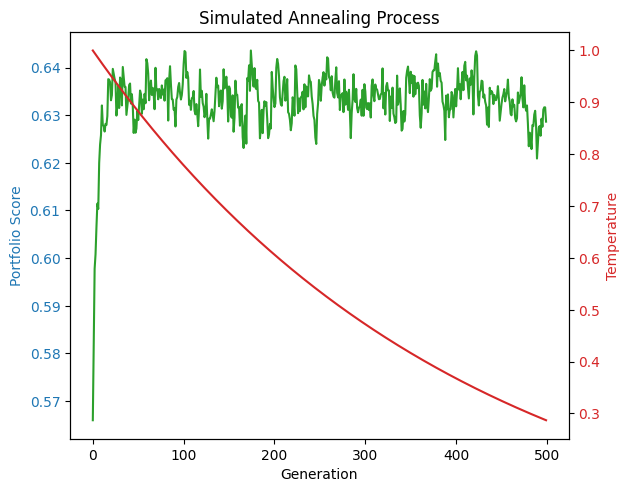

In [16]:
import random
import math
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import json

# === Precomputation Function === #
def precompute_heuristics(stock_data):
    """
    Precompute heuristics for all stocks to avoid redundant calculations.

    Args:
        stock_data (dict): Dictionary containing stock data for multiple stocks

    Returns:
        dict: Dictionary of precomputed heuristic values {stock: {hold_long: val, hold_short: val}}
    """
    precomputed = {}
    for stock, prices in stock_data.items():
        if not prices:
            continue

        stock_obj = {
            "symbol": stock,
            "prices": prices
        }

        # Calculate heuristics once per stock
        precomputed[stock] = calculate_heuristics(stock_obj)

    return precomputed

# === Optimized Portfolio Scoring === #
def heuristic_function(stock, precomputed_heuristics=None, stock_data=None, term="long") -> float:
    """
    Returns the heuristic value (hold score) of a single stock.
    Args:
        stock (str): Stock symbol, e.g., "AAPL"
        precomputed_heuristics (dict): Dictionary of precomputed heuristic values
        stock_data (dict): Dictionary containing stock data (used as fallback if precomputed not available)
        term (str): "long" or "short" for investment horizon
    Returns:
        float: Heuristic score for hold decision
    """
    # Use precomputed values if available
    if precomputed_heuristics is not None and stock in precomputed_heuristics:
        result = precomputed_heuristics[stock]
    else:
        # Fallback to original calculation if precomputed not available
        if stock_data is None:
            raise ValueError("Either precomputed_heuristics or stock_data must be provided")

        # Get prices for the given stock symbol
        stock_prices = stock_data[stock]
        if not stock_prices:
            raise ValueError(f"No price data found for stock symbol: {stock}")

        # Create a stock dictionary in the expected format
        stock_obj = {
            "symbol": stock,
            "prices": stock_prices
        }

        # Get heuristic scores
        result = calculate_heuristics(stock_obj)

    if term == "long":
        return result["hold_long"]
    elif term == "short":
        return result["hold_short"]
    else:
        raise ValueError("term must be either 'long' or 'short'")


def portfolio_score(portfolio, precomputed_heuristics=None, stock_data=None, term="long") -> float:
    """
    Calculates the score of the portfolio using either precomputed values or raw stock data.
    """
    if precomputed_heuristics is None and stock_data is None:
        raise ValueError("Either precomputed_heuristics or stock_data must be provided")

    return sum(heuristic_function(stock, precomputed_heuristics, stock_data, term) * weight
               for stock, weight in portfolio.items())

# === Neighbor Generator === #
def generate_neighbor(portfolio, stock_data=None, noise_scale=0.05, num_neighbors=10, diversification=0.25, max_attempts=1000) -> list:
    """
    Generate a list of unique neighboring portfolios with diversification constraints.
    """
    stocks = list(portfolio.keys())
    neighbors = []
    seen = set()
    attempts = 0

    while len(neighbors) < num_neighbors and attempts < max_attempts:
        attempts += 1

        new_weights = []
        for stock in stocks:
            perturb = random.uniform(-noise_scale, noise_scale)
            new_weight = max(0.0, portfolio[stock] + perturb)
            new_weights.append(new_weight)

        total = sum(new_weights)
        if total == 0:
            continue

        normalized_weights = [w / total for w in new_weights]

        if any(weight > diversification for weight in normalized_weights):
            continue

        key = tuple(normalized_weights)
        if key in seen:
            continue
        seen.add(key)

        neighbor = {stock: weight for stock, weight in zip(stocks, normalized_weights)}
        neighbors.append(neighbor)

    return neighbors


# === Optimized Simulated Annealing === #
def simulated_annealing(initial_portfolio, stock_data, term="long", initial_temp=1.0, cooling_rate=0.9975, max_iter=500, num_neighbors=10, diversification=0.25):
    """
    Simulated Annealing to optimize a portfolio (dict of stock:weight) with diversification constraints.
    Uses precomputation for improved performance.
    """
    # Precompute all heuristics once
    precomputed_heuristics = precompute_heuristics(stock_data)

    current_portfolio = initial_portfolio.copy()
    current_score = portfolio_score(current_portfolio, precomputed_heuristics=precomputed_heuristics, term=term)

    best_portfolio = current_portfolio.copy()
    best_score = current_score
    temp = initial_temp

    scores = []
    temperatures = []

    for iteration in range(max_iter):
        neighbors = generate_neighbor(current_portfolio, num_neighbors=num_neighbors, diversification=diversification)
        scored_neighbors = [(neighbor, portfolio_score(neighbor, precomputed_heuristics=precomputed_heuristics, term=term))
                           for neighbor in neighbors]

        if not scored_neighbors:
            break  # No valid neighbors, stop the process

        best_candidate, best_candidate_score = max(scored_neighbors, key=lambda x: x[1])
        delta = best_candidate_score - current_score

        if delta > 0 or random.random() < math.exp(delta / temp):
            current_portfolio = best_candidate
            current_score = best_candidate_score

            if current_score > best_score:
                best_portfolio = current_portfolio.copy()
                best_score = current_score

        scores.append(current_score)
        temperatures.append(temp)

        temp = max(temp * cooling_rate, 1e-8)

    return best_portfolio, best_score, scores, temperatures

# === Plotting Function === #
def plot_simulated_annealing(scores, temperatures):
    """
    Plots the simulated annealing process.
    """
    generations = range(len(scores))

    fig, ax1 = plt.subplots()

    # Plot portfolio scores
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Portfolio Score', color='tab:blue')
    ax1.plot(generations, scores, label='Portfolio Score', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot temperature on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Temperature', color='tab:red')
    ax2.plot(generations, temperatures, label='Temperature', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('Simulated Annealing Process')
    plt.show()

def print_portfolio(portfolio, title="Portfolio Allocation"):

    # Sort stocks by allocation (descending)
    sorted_items = sorted(portfolio.items(), key=lambda x: x[1], reverse=True)

    # Calculate total for verification
    total = sum(weight for _, weight in sorted_items)

    # Print header
    print("\n" + "="*50)
    print(f"{title} (Total: {total:.5f})")
    print("="*50)
    print(f"{'Stock':<10} | {'Allocation':>12} | {'Percentage':>10}")
    print("-"*50)

    # Print each stock allocation
    for stock, weight in sorted_items:
        percentage = weight * 100
        print(f"{stock:<10} | {weight:>12.5f} | {percentage:>9.2f}%")

    print("="*50)


if __name__ == "__main__":
    # Example stock symbols and date range
    term = "short"

    stock_symbols = get_filtered_stocks(update=False)["top_long_term"] if term == "long" else get_filtered_stocks(update=False)["top_short_term"]

    start_date = '2023-01-01'
    end_date = '2023-12-31'

    # Get stock data
    raw_data = get_stock_data(stock_symbols, start_date, end_date)
    stock_data = {item["symbol"]: item["prices"] for item in raw_data}

    # Example portfolio (you can replace this with real data)
    portfolio_long = stock_symbols  # This would be a list of stock tickers
    initial_portfolio = {stock: 1 / len(portfolio_long) for stock in portfolio_long}

    # Print initial portfolio
    print_portfolio(initial_portfolio, "Initial Portfolio")

    # Optimize portfolio using simulated annealing
    optimized_portfolio, score, scores, temperatures = simulated_annealing(initial_portfolio, stock_data, term)

    # Print results in beautiful format
    print_portfolio(optimized_portfolio, "Optimized Portfolio")
    print(f"Portfolio Score: {score:.4f}")

    # Plot the process
    plot_simulated_annealing(scores, temperatures)

- General search

In [17]:
def search(stocks , start_date, end_date):
   T = get_stock_data(stocks, start_date, end_date)
   print("this is the stock data ",T)
   minlen = min( len(T[i]["prices"])  for i in range(len(T)) )
   #minlen = len(T[0]["prices"])
   T_search = [[]for i in range( minlen )]
   for stock in T :
       for i in range( minlen ):
         T_search[i].append({"symbol" : stock["symbol"] , "price" : stock["prices"][i] })

   return  T , T_search


---
3.Testing :
---

In [18]:
constraints = {"preferred_risk":"moderate","investment_duration":"short_term"}
def adapter(stocks , portfolio , constraints ):
  res = []
  for stock in stocks:
    main = {"stock": stock["symbol"], "price":  stock["price"], "amt":  portfolio.get_stock(stock["symbol"]) }
    node = {
        "symbol": stock["symbol"] ,
        "value": main["price"] * main["amt"] ,
        "stock": stock["symbol"] ,
        "eval_por": lambda stocks: sum(s["price"]* ( portfolio.get_stock(stock["symbol"]) ) for s in stocks)
    }
    ac_res  = expand(node, main, portfolio , constraints , stocks)

  return ac_res

In [19]:
def apply_acts(path, portfolio):
  for node in path :
    if node.action == "buy":
      portfolio.buy(node.symbol , node.value)
    elif node.action == "sell":
      portfolio.sell(node.symbol , node.value)


In [20]:
from copy import deepcopy
from datetime import datetime, timedelta
df = load_merged_data()
top_tech_stocks =  get_top_long_term(df)
top_tech_short = get_top_short_term(df)

In [21]:
from copy import deepcopy
from datetime import datetime, timedelta

def get_time_frame(years=1, months=0):
    """Calculate date range based on years and months offset from pivot date (2023-01-01).

    Args:
        years: Number of years for the time frame (default 1)
        months: Additional months to add (default 0)

    Returns:
        tuple: (start_date, end_date) in 'YYYY-MM-DD' format

    Behavior:
        - With years=1: returns ('2023-01-01', '2024-01-01')
        - With years=2: returns ('2022-01-01', '2024-01-01')
        - Months are added to the end date
    """
    pivot_date = "2023-01-01"
    pivot = datetime.strptime(pivot_date, "%Y-%m-%d")

    # Calculate start date (years-1 before pivot)
    start = pivot - timedelta(days=365*(years-1))
    max_end = pivot + timedelta(days=365) + timedelta(days=30*months)
    end =  max_end

    return start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")

def get_past_frames(history, cutoff_index):
    """Return historical data up to the specified index"""
    return [
        {**stock, "prices": stock["prices"][0:cutoff_index]}
        for stock in history
    ]

def calculate_portfolio_value(portfolio, current_prices):
    """Calculate total value of the portfolio"""
    return sum(
        stock_data.amt * current_prices.get(stock_data.stock, 0)
        for stock_data in portfolio.stocks
    )

def run_simulation(stocks  = top_tech_stocks  , initial_capital=2000, years=1, months=0):
    """Main simulation function"""
    # Setup time frame and get historical data
    start_date, end_date = get_time_frame(years=years, months=months)

    short_term = False
    if years <  2 :
      short_term = True
    history, frames = search( stocks, start_date, end_date)
    # Initialize portfolio
    portfolio = Stocks(initial_capital)
    last_stock = stocks[-1]
    # Run time frame search
    for i in range(26, len(frames)):
        # Get historical data up to current point
        past_frames = get_past_frames(history, i)
        history_heuristic = {item["symbol"]: item for item in past_frames}
        expanded =adapter (frames[i],portfolio , constraints )
        nodes = setNodes(expanded, history_heuristic,  short_term )
        best_node = greedy_search(nodes[0], last_stock , portfolio, frames[i])
        apply_acts(get_path(best_node)[1:], portfolio)

    # Display results
    portfolio.display_portfolio()

    current_prices = {fr["symbol"]: fr["price"] for fr in frames[-1]}
    total_value = calculate_portfolio_value(portfolio, current_prices)

    print("Total Portfolio Value:", total_value)
    return total_value

# Example usage:
# 1 year simulation (default)
run_simulation(  top_tech_stocks   , 3000 , 1)

# 2 year simulation with 3 additional months
# run_simulation(years=2, months=3)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


this is the stock data  [{'symbol': 'AEP', 'prices': [86.01048278808594, 86.59976959228516, 85.02227020263672, 87.51545715332031, 88.8028564453125, 88.1954116821289, 88.51272583007812, 87.40666961669922, 85.98326873779297, 86.00141906738281, 83.81646728515625, 83.07303619384766, 83.56261444091797, 84.0068588256836, 84.04312133789062, 83.72579193115234, 84.30603790283203, 84.37857055664062, 84.19725799560547, 85.18545532226562, 85.81103515625, 85.7203598022461, 83.50820922851562, 83.86180114746094, 83.66233825683594, 81.93977355957031, 80.96072387695312, 82.85478973388672, 83.34890747070312, 82.79074096679688, 83.19334411621094, 82.9920425415039, 84.5567398071289, 83.1292953491211, 83.10185241699219, 83.0011978149414, 82.74498748779297, 82.41558837890625, 80.49406433105469, 79.02088165283203, 80.5123519897461, 81.51886749267578, 81.77507019042969, 81.09796905517578, 81.71102905273438, 81.21691131591797, 80.09143829345703, 81.78421783447266, 82.58029174804688, 84.72145080566406, 84.19072

4573.381927490234

# A* search simulation :

In [22]:
from copy import deepcopy
from datetime import datetime, timedelta

def get_time_frame(years=1, months=0):
    """Calculate date range based on years and months offset from pivot date (2023-01-01).

    Args:
        years: Number of years for the time frame (default 1)
        months: Additional months to add (default 0)

    Returns:
        tuple: (start_date, end_date) in 'YYYY-MM-DD' format

    Behavior:
        - With years=1: returns ('2023-01-01', '2024-01-01')
        - With years=2: returns ('2022-01-01', '2024-01-01')
        - Months are added to the end date
    """
    pivot_date = "2023-01-01"
    pivot = datetime.strptime(pivot_date, "%Y-%m-%d")

    # Calculate start date (years-1 before pivot)
    start = pivot - timedelta(days=365*(years-1))
    max_end = pivot + timedelta(days=365) + timedelta(days=30*months)
    end =  max_end

    return start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")

def get_past_frames(history, cutoff_index):
    """Return historical data up to the specified index"""
    return [
        {**stock, "prices": stock["prices"][0:cutoff_index]}
        for stock in history
    ]

def calculate_portfolio_value(portfolio, current_prices):
    """Calculate total value of the portfolio"""
    return sum(
        stock_data.amt * current_prices.get(stock_data.stock, 0)
        for stock_data in portfolio.stocks
    )

def run_simulation(stocks = top_tech_stocks, initial_capital=2000, years=1, months=0):
    """Main simulation function"""
    # Setup time frame and get historical data
    start_date, end_date = get_time_frame(years=years, months=months)

    history, frames = search( stocks, start_date, end_date)


    short_term = False
    if years < 2 :
      short_term = True
    # Initialize portfolio
    portfolio = Stocks(initial_capital)
    last_stock = stocks[-1]
    # Run time frame search
    for i in range(26, len(frames)):
        # Get historical data up to current point
        past_frames = get_past_frames(history, i)
        history_heuristic = {item["symbol"]: item for item in past_frames}
        expanded =adapter (frames[i],portfolio , constraints )
        nodes = setNodes(expanded, history_heuristic,  short_term )
        best_node = A_star_search(nodes[0], last_stock , portfolio, frames[i])
        apply_acts(get_path(best_node)[1:], portfolio)

    # Display results
    portfolio.display_portfolio()

    current_prices = {fr["symbol"]: fr["price"] for fr in frames[-1]}
    total_value = calculate_portfolio_value(portfolio, current_prices)

    print("Total Portfolio Value:", total_value)
    return total_value

# Example usage:
# 1 year simulation (default)
run_simulation( top_tech_stocks , 3000 , 1)

# 2 year simulation with 3 additional months
# run_simulation(years=2, months=3)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


this is the stock data  [{'symbol': 'AEP', 'prices': [86.01048278808594, 86.59976959228516, 85.02227020263672, 87.51545715332031, 88.8028564453125, 88.1954116821289, 88.51272583007812, 87.40666961669922, 85.98326873779297, 86.00141906738281, 83.81646728515625, 83.07303619384766, 83.56261444091797, 84.0068588256836, 84.04312133789062, 83.72579193115234, 84.30603790283203, 84.37857055664062, 84.19725799560547, 85.18545532226562, 85.81103515625, 85.7203598022461, 83.50820922851562, 83.86180114746094, 83.66233825683594, 81.93977355957031, 80.96072387695312, 82.85478973388672, 83.34890747070312, 82.79074096679688, 83.19334411621094, 82.9920425415039, 84.5567398071289, 83.1292953491211, 83.10185241699219, 83.0011978149414, 82.74498748779297, 82.41558837890625, 80.49406433105469, 79.02088165283203, 80.5123519897461, 81.51886749267578, 81.77507019042969, 81.09796905517578, 81.71102905273438, 81.21691131591797, 80.09143829345703, 81.78421783447266, 82.58029174804688, 84.72145080566406, 84.19072

4422.689674377441

#Virtual testing


In [23]:
import sys
import io
from contextlib import contextmanager

@contextmanager
def suppress_print_ctx():
    """Temporarily suppresses print within a `with` block."""
    original_stdout = sys.stdout
    sys.stdout = io.StringIO()
    try:
        yield
    finally:
        sys.stdout = original_stdout  # Always restore

In [24]:
from copy import deepcopy
from datetime import datetime, timedelta

def get_time_frame(years=1, months=0 ):
    """Calculate date range based on years and months offset from pivot date (2023-01-01).

    Args:
        years: Number of years for the time frame (default 1)
        months: Additional months to add (default 0)

    Returns:
        tuple: (start_date, end_date) in 'YYYY-MM-DD' format

    Behavior:
        - With years=1: returns ('2023-01-01', '2024-01-01')
        - With years=2: returns ('2022-01-01', '2024-01-01')
        - Months are added to the end date
    """
    pivot_date = "2023-01-01"
    pivot = datetime.strptime(pivot_date, "%Y-%m-%d")

    # Calculate start date (years-1 before pivot)
    start = pivot - timedelta(days=365*(years-1))
    max_end = pivot + timedelta(days=365) + timedelta(days=30*months)
    end =  max_end

    return start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")

def get_past_frames(history, cutoff_index):
    """Return historical data up to the specified index"""
    return [
        {**stock, "prices": stock["prices"][0:cutoff_index]}
        for stock in history
    ]

def calculate_portfolio_value(portfolio, current_prices):
    """Calculate total value of the portfolio"""
    return sum(
        stock_data.amt * current_prices.get(stock_data.stock, 0)
        for stock_data in portfolio.stocks
    )

def run_graph_simulation(stocks = top_tech_stocks, initial_capital=2000, years=1, months=0 ,  greedy = False):
    """Main simulation function"""
    # Setup time frame and get historical data
    with suppress_print_ctx():
      start_date, end_date = get_time_frame(years=years, months=months)

      history, frames = search( stocks, start_date, end_date)


      short_term = False
      if years < 2 :
        short_term = True
      # Initialize portfolio
      portfolio = Stocks(initial_capital)
      last_stock = stocks[-1]
    # Run time frame search
    for i in range(26, len(frames)):
        # Get historical data up to current point
        with suppress_print_ctx():
          past_frames = get_past_frames(history, i)
          history_heuristic = {item["symbol"]: item for item in past_frames}
          expanded =adapter (frames[i],portfolio , constraints )
          nodes = setNodes(expanded, history_heuristic,  short_term )
          best_node = A_star_search(nodes[0], last_stock , portfolio, frames[i]) if not greedy else  greedy_search(nodes[0], last_stock , portfolio, frames[i])
          apply_acts(get_path(best_node)[1:], portfolio)



    current_prices = {fr["symbol"]: fr["price"] for fr in frames[-1]}
    total_value = calculate_portfolio_value(portfolio, current_prices)

    return total_value + portfolio.get_funds()

# Example usage:
# 1 year simulation (default)
run_graph_simulation( top_tech_stocks , 500 , 1 , True)

# 2 year simulation with 3 additional months
# run_simulation(years=2, months=3)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


515.4243049621582

#CSP


In [25]:
def calculate_trading_scores(stock_data):
    """
    Calculate trading scores with proper reward/penalty system.
    Scores can be positive (reward) or negative (penalty).
    """
    # Calculate all metrics

    var, cvar = get_var_and_cvar(stock_data)
    sharpe = get_sharpe_ratio(stock_data)
    sortino = get_sortino_ratio(stock_data)
    rsi = get_RSI(stock_data)
    macd = get_MacD(stock_data)
    momentum_short = calc_Momentum(stock_data, short=True)
    momentum_long = calc_Momentum(stock_data, short=False)

    scores = {
        "buy_score_short": 0,
        "buy_score_long": 0,
        "sell_score_short": 0,
        "sell_score_long": 0,
        "hold_score_short": 0,
        "hold_score_long": 0
    }

    # --- Buy Signals ---
    # Short-term (momentum, MACD, RSI)
    scores["buy_score_short"] += momentum_short * 0.4  # Positive momentum rewarded
    scores["buy_score_short"] += (macd * 0.3) if macd else 0  # Positive MACD rewarded
    scores["buy_score_short"] += (30 - rsi)/30 * 0.3  # Oversold condition rewarded

    # Long-term (Sharpe, Sortino, Risk)
    scores["buy_score_long"] += sharpe * 0.3
    scores["buy_score_long"] += sortino * 0.3
    scores["buy_score_long"] += (0.1 - abs(var)) * 2  # Lower VaR rewarded
    scores["buy_score_long"] += momentum_long * 0.2

    # --- Sell Signals ---
    # Short-term
    scores["sell_score_short"] += (-momentum_short * 0.4)  # Negative momentum rewarded
    scores["sell_score_short"] += (-macd * 0.3) if macd else 0  # Negative MACD rewarded
    scores["sell_score_short"] += (rsi - 70)/30 * 0.3  # Overbought condition rewarded

    # Long-term
    scores["sell_score_long"] += (-sharpe * 0.3)  # Negative Sharpe rewarded
    scores["sell_score_long"] += (abs(cvar) - 0.2) * 3  # High CVaR rewarded
    scores["sell_score_long"] += (-momentum_long * 0.2)
    scores["sell_score_long"] += (-sortino * 0.2)

    # --- Hold Signals ---
    neutral_rsi = 1 - abs(rsi-50)/50  # Closer to 50 is better
    scores["hold_score_short"] += neutral_rsi * 0.5
    scores["hold_score_short"] += (0.05 - abs(momentum_short)) * 10  # Neutral momentum

    scores["hold_score_long"] += (1 - abs(sharpe)) * 0.4  # Neutral Sharpe
    scores["hold_score_long"] += (1 - abs(sortino)) * 0.4
    scores["hold_score_long"] += (0.125 - abs(abs(var)-0.125)) * 8  # Mid-range VaR
    return scores

In [26]:
from contextlib import contextmanager
import sys
import os

@contextmanager
def no_prints():
    """Context manager that suppresses all print output"""
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    try:
        yield
    finally:
        sys.stdout.close()
        sys.stdout = original_stdout

In [27]:
import statistics
import traceback

from copy import deepcopy
from datetime import datetime, timedelta

"""
CSPTrader - A Constraint Satisfaction Problem Approach to Stock Trading

Purpose:
This class implements a constraint-based trading system that evaluates stocks based on technical indicators
and risk metrics to make buy/sell/hold decisions while maintaining portfolio-level constraints.

Key Components:
1. Portfolio Management: Tracks stocks, funds, and investment horizon
2. Constraint System: Enforces trading rules at both individual stock and portfolio levels
3. Decision Engine: Evaluates trading actions against constraints

Data Requirements:
- Historical stock price data (can be fetched from any data source)
- Technical indicators (RSI, MACD)
- Risk metrics (VaR, CVaR)

Implementation Status:
✔ Working: Stock data organization, individual constraint calculations
✖ TODO: Portfolio-level constraints, complete CSP solver implementation
"""

class CSPTrader:
    def __init__(self, stocks, funds, years=3, months=0):
        """
        Initialize the CSP trader with portfolio parameters

        Args:
            stocks (list): List of stock symbols to consider (e.g., ['AAPL', 'MSFT'])
            funds (float): Initial capital available for trading
            years (int): Investment horizon in years (default 1)
            months (int): Additional months to investment horizon (default 0)

        Attributes:
            short (bool): Flag indicating short-term trading (horizon ≤1 year)
            portfolio (Stocks): Portfolio management object
            constraints (dict): Stores constraint definitions
        """
        self.stocks = stocks
        self.years = years
        self.months = months
        self.portfolio = Stocks(funds)  # Assumes Stocks class exists
        self.funds = funds
        self.constraints = {}
        # Determine if this is short-term trading (≤1 year)
        self.short = not (years > 1 or (years == 1 and months > 0))
        self.setDate()  # Initialize date ranges
        self.domain= [-1,0,1]  # same domains fro all variables


    def setDate(self):
        """
        Set the start and end dates for analysis based on investment horizon

        Logic:
        - For horizons ≤1 year: Uses 2023-2024 as base period
        - For horizons >1 year: Extends backward from 2024
        - Always maintains date format as yyyy-mm-dd

        Modifies:
            self.start_date, self.end_date
        """
        now = datetime.now()
        Date_FormS = Date_FormE = now.date()
        Date_FormS = Date_FormS.replace(year=2023)
        Date_FormE = Date_FormE.replace(year=2024)

        if self.years <= 1:
            if self.years == 0:
                Date_FormS = Date_FormS.replace(year=2024)
                Date_FormS = Date_FormS - timedelta(days=30*self.months)
            else:
                Date_FormS = Date_FormS - timedelta(days=30*self.months)
        else:
            if self.months == 0:
                Date_FormS = Date_FormS.replace(year=Date_FormS.year - (self.years - 1))
                Date_FormE = Date_FormE.replace(year=2024)
            else:
                Date_FormS = Date_FormS.replace(year=Date_FormS.year - (self.years - 2))
                Date_FormE = Date_FormE + timedelta(days=30*self.months)

        self.start_date = Date_FormS.strftime("%Y-%m-%d")
        self.end_date = Date_FormE.strftime("%Y-%m-%d")

    def search(self):
        """
        Fetch and organize stock data for analysis


        Returns:
            tuple: (full historical data, time-sliced search data)
                   - T: Complete historical data for each stock
                   - T_search: Data organized by time period for analysis
        """
        stocks = self.stocks
        T = get_stock_data(stocks, self.start_date, self.end_date)
        minlen = min(len(T[i]["prices"]) for i in range(len(T)))
        T_search = [[] for _ in range(minlen)]

        for stock in T:
            for i in range(minlen):
                T_search[i].append({
                    "symbol": stock["symbol"],
                    "price": stock["prices"][i]
                })
        return T, T_search

    def getPast(self, s_hist, i):
        """
        Get historical data up to a specific time index

        Args:
            s_hist (list): Full stock history
            i (int): Time index cutoff

        Returns:
            list: Stock data up to time index i for each stock
        """
        return [{
            "symbol": st["symbol"],
            "prices": st['prices'][:i]
        } for st in s_hist]

    def calculate_danger(self, stock_data):
        """
        Calculate normalized danger score combining VaR and CVaR

        Args:
            stock_data (dict): Stock data including price history

        Returns:
            float: Normalized danger score (0-1) where higher is more dangerous
                   Computed as: 0.6*VaR + 0.4*CVaR (normalized to [0,1] range)
        """
        print ("look here ######### :" , stock_data)
        var, cvar = get_var_and_cvar(stock_data)
        # Normalize to [0,1] range (assuming VaR/CVaR are negative for losses)
        norm_var = abs(min(-0.05, var)) / 0.3  # Cap at 30% daily loss
        norm_cvar = abs(cvar) / 0.4  # Cap at 40% tail loss
        return 0.6 * norm_var + 0.4 * norm_cvar

    def calculate_stability(self, stock_data):
        """
        Calculate price stability as drawdown from recent peak

        Args:
            stock_data (dict): Stock data including price history

        Returns:
            float: Stability metric (0-1) where higher is less stable
                   Computed as: (peak - current)/peak
        """
        prices = stock_data["prices"]
        lookback = 5 if self.short else len(prices) // 2
        recent_prices = prices[-lookback:]
        peak = max(recent_prices)
        current = recent_prices[-1]
        return (peak - current) / peak

    def global_constraints(self, activePath, prices):
        """
        Calculate portfolio-level constraint metrics

        Args:
            activePath (dict): Current portfolio allocations
            prices (dict): Current price data for all stocks

        Returns:
            tuple: (average danger score, average stability score)
        """
        dangers = []
        stability = []
        print("hello active ",activePath)
        print("hello prices",prices)
        for stock in activePath:
            target_prices = next((stck["prices"] for stck in prices if stck["symbol"] == stock), None)
            if not target_prices:
               return
            dang = self.calculate_danger({"symbol": stock, "prices": target_prices})
            stab = self.calculate_stability({"symbol": stock, "prices": target_prices})
            dangers.append(dang)
            stability.append(stab)
        return statistics.mean(dangers), statistics.mean(stability)


    def getPortfolioAllocation(self, assignment, symbol, current_prices,prices):
        """
        Calculate current allocation percentage for a stock

        Args:
            assignment (dict): Current portfolio assignments
            symbol (str): Stock symbol to check

        Returns:
            float: Percentage of total stock  value in this portfolio (0-1)
        """
        if not assignment or symbol not in assignment:
            return 0.0
        shares, _= assignment[symbol]

        if symbol in [stock["symbol"] for stock in prices]:
              print
              amount =  shares * current_prices[symbol]
        else:
              print("price not found2")
              return 0.0
        if  self.funds != 0:
            return amount / self.funds
        else :
            print ("amount",amount)
            print ("self.funds",)
            print("An error occured when calculating the allocation! ghofrane")
            return 0.0


    def can_be_bought(self, symbol, budget_holder, assignment,current_prices, prices,n):
        """
        Check if buying a stock would exceed available funds

        Args:
            symbol (str): Stock symbol to check
            portfolio (float): Total portfolio value  ##################
            assignment (dict): Current portfolio assignments
            prices (dict): Current stock prices


        Returns:
            bool: True if purchase is within budget, False otherwise
        """
        total_value = 0
        copy_budget = budget_holder.get(n)

        if copy_budget is None:
            copy_budget = budget_holder.get(n - 1)
            if copy_budget is None:
                copy_budget = self.funds
        for stock_symbol, (shares, _) in assignment.items():

            if stock_symbol  in  current_prices:
                if stock_symbol == symbol:
                    stock_value = current_prices[symbol]
                    break
            else:
              print("price not found")
              return 0.0
        return stock_value <= copy_budget


    def assign(self, symbol, value, assignment, prices, current_prices, budget_holder, n):
          """
          Assign a trade action with very light constraints for broader CSP exploration.

          Args:
              symbol (str): Stock symbol to trade
              value (int): Trade action (-1=sell, 0=hold, 1=buy)
              assignment (dict): Current portfolio state {symbol: (shares, pnl)}
              prices (list): List of stock data dictionaries

          Returns:
              bool: True if assignment is acceptable, False otherwise
          """

          # Relaxed base thresholds
          base = {
              'buy_short': 0.2,
              'buy_long': 0.15,
              'sell_short': 0.15,
              'sell_long': 0.1,
              'hold_short': 0.1,
              'hold_long': 0.15
          }

          temp = 0.03 * n

          for score in base:
              base[score] = base[score] - temp

          # Quick symbol validation
          if symbol not in [stock["symbol"] for stock in prices]:
              return False

          # Get historical prices
          target_prices = next((stock["prices"] for stock in prices if stock["symbol"] == symbol), None)
          if not target_prices:
              return False

          current_shares, _ = assignment.get(symbol, (0, 0))

          # Allow selling only if shares exist
          if value == -1 and current_shares <= 0:
              return False

          # Relaxed buy constraints
          elif value == 1:
              allocation = self.getPortfolioAllocation(assignment, symbol, current_prices, prices)
              if allocation >= 0.2:  # relaxed from 0.2
                  return False
              # Skip budget check completely (for looser exploration)
              if not self.can_be_bought( symbol, budget_holder, assignment,current_prices, prices,n):
                 return False

          # Score-based decision (relaxed)
          score = calculate_trading_scores({"symbol": symbol, "prices": target_prices})

          case_con = (
              "buy_short" if self.short else "buy_long" if value == 1 else
              "sell_short" if self.short else "sell_long" if value == -1 else
              "hold_short" if self.short else "hold_long"
          )
          score_key = case_con.replace("_", "_score_")
          return score.get(score_key, 1) >= base.get(case_con, 0)  # allow if missing or weak

    def global_assign(self, assignment, current_prices, prices):
        """
        Validate an assignment against portfolio-level constraints (relaxed)

        Args:
            assignment (dict): Current portfolio assignments
            prices (dict): Current stock prices

        Returns:
            bool: True if assignment passes relaxed global constraints
        """
        activePath = {stock: assignment[stock] for stock in assignment if assignment[stock][1] is not None}
        stocks = list(activePath.keys())

        prix = {stock: current_prices[stock] for stock in stocks}

        # Calculate initial and proposed states
        initial = {stock: assignment[stock][0] for stock in assignment}
        applied = {
            stock: assignment[stock][0] + (assignment[stock][1] if assignment[stock][1] is not None else 0)
            for stock in assignment
        }

        # Compare danger and stability metrics
        dang_initial = self.global_constraints(initial, prices)[0]
        applied_dang, appl_stab = self.global_constraints(applied, prices)

        # RELAXED danger constraint: allow up to 10% danger increase
        if applied_dang > dang_initial * 1.0:
            return False

        # RELAXED stability constraint: allow up to 0.4 instability
        if appl_stab > 0.4:
            return False

        return True

    def initialize_assignment(self):
      """
      Initialize trading assignments for all stocks in the portfolio

      Returns:
          dict: Dictionary mapping each stock symbol to a tuple of:
                (current_shares, action) where action is initialized to None
                Example: {'AAPL': (100, None), 'TSLA': (50, None)}

      Note:
          - Uses portfolio.get_stock() to get current share counts
          - All actions start as None (no action taken yet)
      """
      return {stock: (self.portfolio.get_stock(stock), None) for stock in self.stocks}

    def apply_assignments(self, assignments, prices):
        """
        Execute buy/sell actions based on the assignment dictionary

        Args:
            assignments (dict): Dictionary of stock assignments {symbol: (shares, action)}
            prices (dict): Current prices for each stock {symbol: price}

        Raises:
            ValueError: If assignment validation fails
            RuntimeError: If portfolio operations fail

        Note:
            - Validates assignments match current portfolio state
            - Executes buy(1)/sell(-1) actions
            - Skips None actions (0 would be hold)
        """
        for stock, (num_shares, action) in assignments.items():
            # Validate assignment matches current portfolio state
            current_shares = self.portfolio.get_stock(stock)
            if num_shares != current_shares or action is None:
                raise ValueError(
                    f"Invalid assignment for {stock}: "
                    f"Expected shares {current_shares}, got {num_shares}. "
                    f"Action: {action}"
                )

            try:
                if action == 1:  # Buy
                    self.portfolio.buy(stock, prices[stock])
                elif action == -1:  # Sell
                    self.portfolio.sell(stock, prices[stock])
                # action 0 or None would be hold (no operation)
            except Exception as e:
                raise RuntimeError(f"Failed to execute {action} for {stock}: {str(e)}")

    def check_complete_assignment(self ,assignments):
        """
        Checks if a current assignment is complete

        Args:
            assignments (dict): Current stock assignments to modify

        Note:
            - This is a stub for actual CSP implementation
            - Should modify assignments in-place with recommended actions
        """

        print (assignments)
        for stock, (shares, action) in assignments.items():
            if action is None:
                return False
        return True


    def apply_csp(self, stock_names, assignments,budget_holder ,current_prices, n=0, prices=None):
          """
          Apply Constraint Satisfaction Problem logic to determine trades

          Args:
              assignments (dict): Current stock assignments to modify

          Note:
              - This is a stub for actual CSP implementation
              - Should modify assignments in-place with recommended actions
          """
          # Check if all stocks have been assigned a value
          if self.check_complete_assignment(assignments):
              # If the assignments are complete, check the global assignment constraints
              if self.global_assign(assignments, current_prices,prices):
                  print("valid solution is found")
                  return assignments  # If valid, return the assignments
              else:
                  print ("一")
                  return assignments  # If not valid, return None

          # If there are more stocks to assign
          if n >= len(stock_names):
              print ("二")
              return assignments   # If all stocks are processed and no solution found

          current = stock_names[n]
          # Try all possible values in the domain for the current stock
          for value in self.domain:
              if self.assign(current, value, assignments, prices,current_prices, budget_holder,n):
                  # Make a copy of the assignments to avoid modifying the original while recursing
                  assignments_copy = deepcopy(assignments)


                  # Update the assignment for the current stock
                  current_shares = assignments_copy[current][0]
                  assignments_copy[current] = (current_shares, value)

                  # If the value is 1, it means we are buying the stock, so update the budget
                  copy_budget = budget_holder.get(n-1, budget_holder.get(n, self.funds))
                  new_budget = copy_budget

                  if value == 1:

                      price = current_prices[current]
                      new_budget -= price
                  if value == -1:
                      price = current_prices[current]
                      new_budget += price
                  budget_copy = deepcopy(budget_holder)
                  budget_copy[n] = new_budget



                  # Recursively apply CSP with the updated assignments and budget
                  result = self.apply_csp(stock_names, assignments_copy, budget_copy, current_prices, n + 1, prices)
                  if result:  # If a valid solution is found, return the result
                    return result

          # If no valid assignment is found for this stock, return None
          #print("no way to do that")
          return None

    import traceback

    def run(self):
          try:
              # Get historical data
              hist_prices, frames = self.search()

              budget_holder = dict()
              budget_holder[0] = self.funds
              # Adapting to the recursion way
              K = 0
              stock_names = []
              for stock in self.stocks:
                stock_names.append(stock)
              print (stock_names)

              # Process each trading frame (starting at day 26 for MA calculations)
              for i in range(26, len(frames)):
                  # Get historical context and current prices
                  historical_prices = self.getPast(hist_prices, i)

                  current_frame = frames[i]
                  current_prices = {stock["symbol"]: stock["price"] for stock in current_frame}

                  # Initialize and process assignments
                  assignments = self.initialize_assignment()


                  assignments = self.apply_csp(stock_names, assignments,budget_holder,current_prices, 0, historical_prices)

                  if assignments is None:
                     #print("⚠️ No valid assignment found. Skipping this trading frame.")
                      pass
                  else:
                     self.apply_assignments(assignments, current_prices)

              # Display final results
              print('\n✅ Trading simulation complete. Final portfolio:')
              self.portfolio.display_portfolio()
              val = 0
              last_prices = { }
              for prix in frames[-1]:
                last_prices[prix["symbol"]] = prix["price"]
              for stock in self.portfolio.stocks:
                val += self.portfolio.get_stock(stock.stock) * last_prices[stock.stock]
              print('the value is ' , val + self.portfolio.funds)


          except Exception as e:
              print(" An error occurred during trading simulation.")
              print("Error type:", type(e).__name__)
              print("Error message:", e)
              print(" Traceback:")
              traceback.print_exc()


    def run_gragh_sim(self):
          with no_prints():
            try:
                # Get historical data
                hist_prices, frames = self.search()

                budget_holder = dict()
                budget_holder[0] = self.funds
                # Adapting to the recursion way
                K = 0
                stock_names = []
                for stock in self.stocks:
                  stock_names.append(stock)
                print (stock_names)

                # Process each trading frame (starting at day 26 for MA calculations)
                for i in range(26, len(frames)):
                    # Get historical context and current prices
                    historical_prices = self.getPast(hist_prices, i)

                    current_frame = frames[i]
                    current_prices = {stock["symbol"]: stock["price"] for stock in current_frame}

                    # Initialize and process assignments
                    assignments = self.initialize_assignment()


                    assignments = self.apply_csp(stock_names, assignments,budget_holder,current_prices, 0, historical_prices)

                    if assignments is None:
                      #print("⚠️ No valid assignment found. Skipping this trading frame.")
                        pass
                    else:
                      self.apply_assignments(assignments, current_prices)

                # Display final results
                print('\n✅ Trading simulation complete. Final portfolio:')
                self.portfolio.display_portfolio()
                val = 0
                last_prices = { }
                for prix in frames[-1]:
                  last_prices[prix["symbol"]] = prix["price"]
                for stock in self.portfolio.stocks:
                  val += self.portfolio.get_stock(stock.stock) * last_prices[stock.stock]


            except Exception as e:
                print(" An error occurred during trading simulation.")
                print("Error type:", type(e).__name__)
                print(" Error message:", e)
                print(" Traceback:")
                traceback.print_exc()
          self.portfolio.display_portfolio()

          return val + self.portfolio.funds

In [28]:
csp_trading_agent = CSPTrader(top_tech_stocks , 2000 , 2 , 0)
csp_trading_agent.run()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


['AEP', 'CRWD', 'DASH', 'DDOG', 'CSGP', 'AMZN', 'CCEP', 'CMCSA', 'AZN', 'AVGO']
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, 0), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), '

#Graph simualtion :

In [45]:
stocks = get_filtered_stocks(update=False)
top_short_stocks =stocks["top_short_term"]
top_long_stocks =stocks["top_long_term"]

import matplotlib.pyplot as plt
import numpy as np

def Graph_Plot(per_Time_unit=False):
    if per_Time_unit:
        # Define time periods to test
        time_periods = [
            (0, 4), (0, 8), (1, 0),
            (1, 6), (2, 0), (3, 0), (5, 0)
        ]
        period_labels = []
        AS_results = []  # False case
        G_results = []   # True case
        CSP_results = []  # CSP case




        for years, months in time_periods:
            label = f"{years}y {months}m" if years else f"{months}m"
            period_labels.append(label)

            print(f"\nRunning simulation for {label}...")
            if (years <= 1  and months == 0 ) or( years== 0 and months <= 12):
                top_tech_stocks = top_short_stocks
            else:
                top_tech_stocks = top_long_stocks

            AS_val = run_graph_simulation(top_tech_stocks, 2000, years, months, False)
            G_val = run_graph_simulation(top_tech_stocks, 2000, years, months, True)
            csp_trading_agent = CSPTrader(top_tech_stocks , 2000 , years , months)
            csp_trading_agent.run()
            CSP_val = csp_trading_agent.run_gragh_sim()

            AS_results.append(AS_val)
            G_results.append(G_val)
            CSP_results.append(CSP_val)



        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(period_labels, AS_results, label='Strategy A* (False)', marker='o', linestyle='-')
        plt.plot(period_labels, G_results, label='Strategy Greedy (True)', marker='s', linestyle='-')
        plt.plot(period_labels, CSP_results, label='Strategy CSP(True)', marker='s', linestyle='-')



        plt.title('Portfolio Performance Over Different Time Periods')
        plt.xlabel('Investment Duration')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        x = y =capital_amounts = [500, 2000, 5000, 7500, 10000]
        AS_results = []  # False case
        G_results = []   # True case
        CSP_results = []  # CSP case

        for capital in capital_amounts:
            print(f"\nRunning 2-year simulation with ${capital:,} initial capital...")
            AS_val = run_graph_simulation(top_long_stocks, capital, 2, 0, False)
            G_val = run_graph_simulation(top_long_stocks, capital, 2, 0, True)
            csp_trading_agent = CSPTrader(top_long_stocks , capital ,2, 0)
            CSP_val = csp_trading_agent.run_gragh_sim()


            AS_results.append(AS_val)
            G_results.append(G_val)
            CSP_results.append(CSP_val)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(capital_amounts, AS_results, label='Strategy A_star', marker='o', linestyle='-')
        plt.plot(capital_amounts, G_results, label='Strategy Greedy ', marker='s', linestyle='-')
        plt.plot(capital_amounts, CSP_results, label='Strategy CSP', marker='s', linestyle='-')
        plt.plot(x, y ,  label='Capital_Inv', marker='o', linestyle='-')
        plt.title('Portfolio Performance vs. Capital (2 Years)')
        plt.xlabel('Initial Capital ($)')
        plt.ylabel('Portfolio Value ($)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

## plot of algorithm comparison per time unit



Running simulation for 4m...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

['CHTR', 'BIIB', 'DASH', 'ADBE', 'CSGP', 'ABNB', 'CMCSA', 'AMD', 'BKR', 'AXON']
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, 0), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, 1), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON':

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Available funds: $2000.00
Stock Portfolio is empty.
------------------------------

Running simulation for 8m...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

['CHTR', 'BIIB', 'DASH', 'ADBE', 'CSGP', 'ABNB', 'CMCSA', 'AMD', 'BKR', 'AXON']
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'CHTR': (0, 0), 'BIIB': (0, 1), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, 1), 'DASH': (0, 0), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, 1), 'DASH': (0, 1), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, 0), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, 0), 'DASH': (0, 0), 'ADBE': (0, None), 'CSGP': (0, Non


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Available funds: $2000.00
Stock Portfolio is empty.
------------------------------

Running simulation for 1y 0m...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

['CHTR', 'BIIB', 'DASH', 'ADBE', 'CSGP', 'ABNB', 'CMCSA', 'AMD', 'BKR', 'AXON']
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, None), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 0), 'BIIB': (0, None), 'DASH': (0, None), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'CHTR': (0, 1), 'BIIB': (0, 1), 'DASH': (0, 1), 'ADBE': (0, None), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, 1), 'DASH': (0, 1), 'ADBE': (0, 0), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}
{'CHTR': (0, 1), 'BIIB': (0, 1), 'DASH': (0, 1), 'ADBE': (0, 1), 'CSGP': (0, None), 'ABNB': (0, None), 'CMCSA': (0, None), 'AMD': (0, None), 'BKR': (0, None), 'AXON': (0, None)}

✅ Trading simulation complete. Final portfolio:

Available funds: $2000.00
Stock Portfolio is empty.
------------------------------
the value is  2000



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Available funds: $2000.00
Stock Portfolio is empty.
------------------------------

Running simulation for 1y 6m...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

['AEP', 'CRWD', 'DASH', 'DDOG', 'CSGP', 'AMZN', 'CCEP', 'CMCSA', 'AZN', 'AVGO']
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, 0), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, 0), 'DASH': (0, 0), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, 0), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}


[*********************100%***********************]  1 of 1 completed

{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (3, 1), 'DDOG': (2, 1), 'CSGP': (0, 0), 'AMZN': (4, None), 'CCEP': (4, None), 'CMCSA': (4, None), 'AZN': (4, None), 'AVGO': (4, None)}
{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (3, 1), 'DDOG': (2, 1), 'CSGP': (0, 1), 'AMZN': (4, None), 'CCEP': (4, None), 'CMCSA': (4, None), 'AZN': (4, None), 'AVGO': (4, None)}
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (3, None), 'DDOG': (2, None), 'CSGP': (0, None), 'AMZN': (4, None), 'CCEP': (4, None), 'CMCSA': (4, None), 'AZN': (4, None), 'AVGO': (4, None)}
{'AEP': (0, 0), 'CRWD': (0, None), 'DASH': (3, None), 'DDOG': (2, None), 'CSGP': (0, None), 'AMZN': (4, None), 'CCEP': (4, None), 'CMCSA': (4, None), 'AZN': (4, None), 'AVGO': (4, None)}
{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (3, None), 'DDOG': (2, None), 'CSGP': (0, None), 'AMZN': (4, None), 'CCEP': (4, None), 'CMCSA': (4, None), 'AZN': (4, None), 'AVGO': (4, None)}
{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (3, 1), 'DDOG': (2, None), 'CSGP': (0, None), 'AM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Available funds: $52.51
Stock Portfolio:
- AMZN: 4 shares
- CCEP: 4 shares
- CMCSA: 4 shares
- AZN: 4 shares
- AVGO: 4 shares
- DASH: 3 shares
- DDOG: 2 shares
------------------------------

Running simulation for 2y 0m...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

['AEP', 'CRWD', 'DASH', 'DDOG', 'CSGP', 'AMZN', 'CCEP', 'CMCSA', 'AZN', 'AVGO']
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, 0), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), '

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, None), 'CSGP': (6, None), 'AMZN': (0, None), 'CCEP': (5, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 0), 'CSGP': (6, None), 'AMZN': (0, None), 'CCEP': (5, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 1), 'CSGP': (6, None), 'AMZN': (0, None), 'CCEP': (5, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (6, None), 'AMZN': (0, None), 'CCEP': (5, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (6, None), 'AMZN': (0, None), 'CCEP': (5, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 0), 'CRWD': (0, 1), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (6, None


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Available funds: $1299.20
Stock Portfolio:
- CSGP: 6 shares
- CCEP: 5 shares
------------------------------

Running simulation for 3y 0m...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, 0), 'AMZN': (0, 0), 'CCEP': (0, 1), 'CMCSA': (0, None), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, 0), 'AMZN': (0, 0), 'CCEP': (0, 1), 'CMCSA': (0, 0), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, 0), 'AMZN': (0, 0), 'CCEP': (0, 1), 'CMCSA': (0, 0), 'AZN': (6, 0), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, 0), 'AMZN': (0, 0), 'CCEP': (0, 1), 'CMCSA': (0, 0), 'AZN': (6, 1), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, 0), 'AMZN': (0, 1), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, 0), 'AMZN': (

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 1), 'CSGP': (0, 1), 'AMZN': (0, 1), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 1), 'CSGP': (0, 1), 'AMZN': (0, 1), 'CCEP': (0, 0), 'CMCSA': (0, None), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 1), 'CSGP': (0, 1), 'AMZN': (0, 1), 'CCEP': (0, 0), 'CMCSA': (0, 0), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 1), 'CSGP': (0, 1), 'AMZN': (0, 1), 'CCEP': (0, 1), 'CMCSA': (0, None), 'AZN': (6, None), 'AVGO': (7, None)}
{'AEP': (0, 1), 'CRWD': (0, 1), 'DASH': (0, 1), 'DDOG': (0, 1), 'CSGP': (0, 1), 'AMZN': (0, 1), 'CCEP': (0, 1), 'CMCSA': (0, 0), 'AZN': (6, None), 'AVGO': (7, None)}

✅ Trading simulation complete. Final portfolio:

Available funds: $1190.54
Stock Portfolio:
- AZN: 6 shares
- AVGO: 7 shares
------------------------------
t


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Available funds: $1071.76
Stock Portfolio:
- AZN: 7 shares
- AVGO: 8 shares
------------------------------

Running simulation for 5y 0m...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

['AEP', 'CRWD', 'DASH', 'DDOG', 'CSGP', 'AMZN', 'CCEP', 'CMCSA', 'AZN', 'AVGO']
{'AEP': (0, None), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, None), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, 0), 'DASH': (0, None), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, 0), 'DASH': (0, 0), 'DDOG': (0, None), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}
{'AEP': (0, 1), 'CRWD': (0, 0), 'DASH': (0, 0), 'DDOG': (0, 0), 'CSGP': (0, None), 'AMZN': (0, None), 'CCEP': (0, None), 'CMCSA': (0, None), 'AZN': (0, None), 'AVGO': (0, None)}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

look here ######### : {'symbol': 'DDOG', 'prices': [36.150001525878906, 32.27000045776367, 34.720001220703125, 35.66999816894531, 31.56999969482422, 34.29999923706055, 34.02000045776367, 32.810001373291016, 40.630001068115234, 41.040000915527344, 40.77000045776367, 35.90999984741211, 38.790000915527344, 38.5099983215332, 36.11000061035156, 37.41999816894531, 40.15999984741211, 41.189998626708984, 42.04999923706055, 46.209999084472656, 47.18000030517578, 47.029998779296875, 45.68000030517578, 45.150001525878906, 43.619998931884766, 35.2599983215332, 33.380001068115234, 34.54999923706055, 34.689998626708984, 36.95000076293945, 40.400001525878906, 41.810001373291016, 44.97999954223633, 51.72999954223633, 67.16000366210938, 73.04000091552734, 71.2699966430664, 70.66000366210938, 78.05000305175781, 86.79000091552734, 84.5, 89.58999633789062, 96.41000366210938, 87.30000305175781, 84.83999633789062, 93.86000061035156, 75.27999877929688, 81.23999786376953, 86.12000274658203, 82.9800033569336, 


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Available funds: $24.00
Stock Portfolio:
- AEP: 6 shares
- CSGP: 6 shares
- AZN: 6 shares
- DDOG: 5 shares
- CMCSA: 5 shares
- DASH: 1 shares
- AMZN: 1 shares
------------------------------


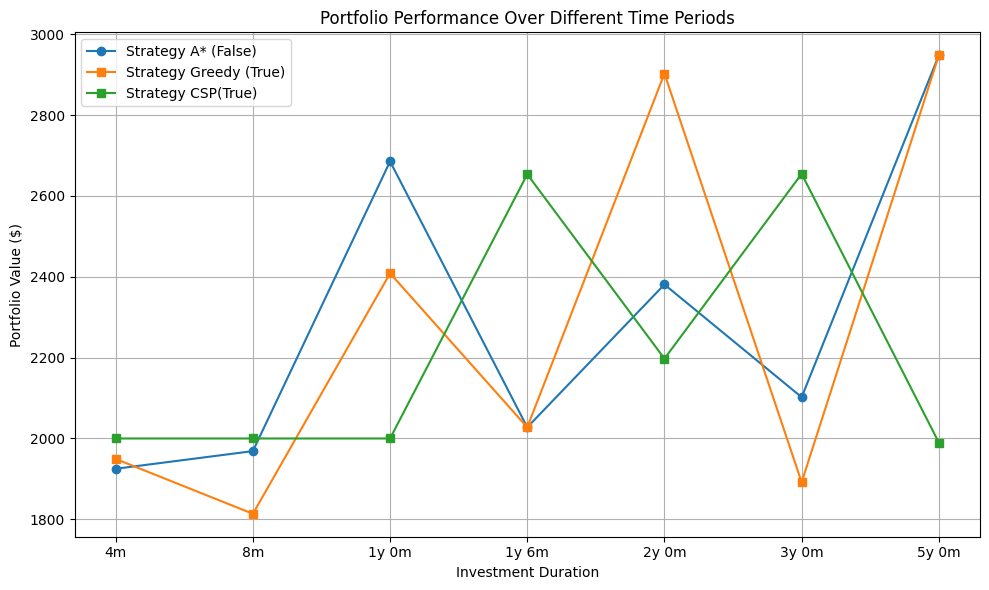

In [32]:
Graph_Plot(True)

## plot of comparison per Capital investement

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AEP', 'CRWD', 'DASH', 'DDOG', 'CSGP', 'AMZN', 'CCEP', 'CMCSA', 'AZN', 'AVGO']

Running 2-year simulation with $500 initial capital...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Available funds: $243.35
Stock Portfolio:
- CSGP: 2 shares
- CCEP: 2 shares
------------------------------

Running 2-year simulation with $2,000 initial capital...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Available funds: $1299.20
Stock Portfolio:
- CSGP: 6 shares
- CCEP: 5 shares
------------------------------

Running 2-year simulation with $5,000 initial capital...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Available funds: $3033.80
Stock Portfolio:
- CSGP: 14 shares
- CCEP: 11 shares
- AZN: 5 shares
------------------------------

Running 2-year simulation with $7,500 initial capital...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Available funds: $4026.69
Stock Portfolio:
- CSGP: 20 shares
- CCEP: 17 shares
- AZN: 10 shares
- AVGO: 4 shares
------------------------------

Running 2-year simulation with $10,000 initial capital...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


Available funds: $4654.06
Stock Portfolio:
- CSGP: 27 shares
- CCEP: 24 shares
- AZN: 14 shares
- AVGO: 11 shares
------------------------------


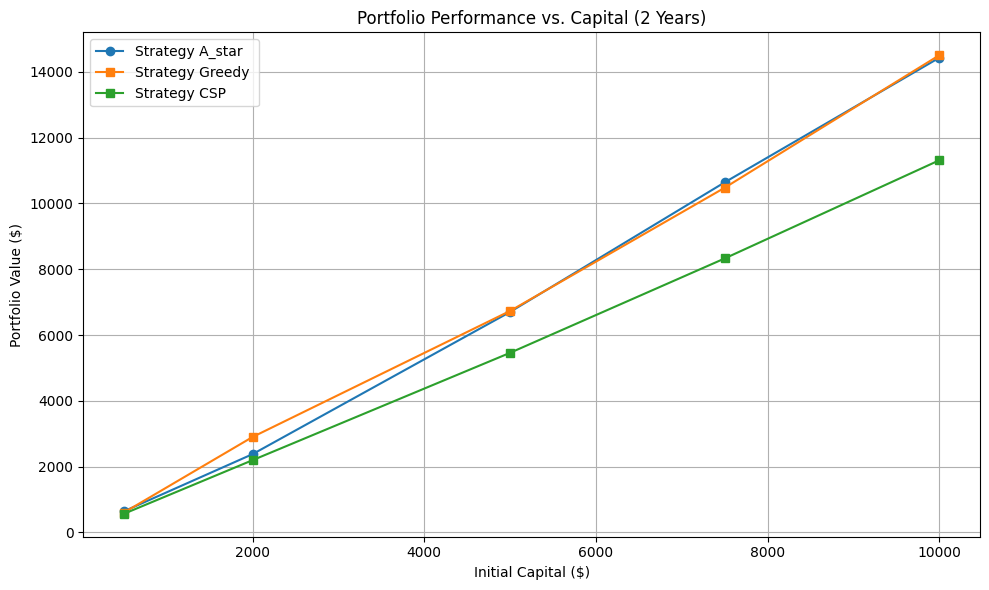

In [46]:

Graph_Plot(False)